# OUTLIER AND MISSING VALUE ANALYSIS
- Will analze the distirbution of missing values
- Results of joins oer dataframe in raw

In [1]:
import os
import sys  
from pathlib import Path
curr_path = str(Path(os.getcwd()).parent)
sys.path.append(curr_path)
from scripts.constants import *
from scripts.read import *
from scripts.plotting import *

In [2]:
spark = create_spark()

your 131072x1 screen size is bogus. expect trouble
23/09/08 06:03:12 WARN Utils: Your hostname, LAPTOP-0SKBJL5H resolves to a loopback address: 127.0.1.1; using 192.168.190.225 instead (on interface eth0)
23/09/08 06:03:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/09/08 06:03:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Read the required dataframes

### MISSING DATA FUNCTION

In [3]:
def get_missing_data_parquet(df: DataFrame):
    """
    Function is primarily used to get missing data from a parquet file
    - Parameters
        - df: Input DataFrame
    - Returns
        - missing_df: DataFrame of missing data
    """
    # Calculate first the original count
    original_count = df.count()

    # Calculate missing value percentages for different data types
    missing_df = df.select(*[
        F.when(F.col(c).isNull(), 1).otherwise(0).alias(c)
        for c, t in df.dtypes if t == "string"
    ] + [
        F.when(F.isnan(F.col(c)) | F.col(c).isNull(), 1).otherwise(0).alias(c)
        for c, t in df.dtypes if t not in ("string", "timestamp", "date", "timestamp_ntz")
    ] + [
        F.when(F.col(c).isNull(), 1).otherwise(0).alias(c)
        for c, t in df.dtypes if t in ("timestamp", "date", "timestamp_ntz")
    ])

    # Calculate missing value percentages as a percentage of total rows
    missing_df = missing_df.select([
        (F.sum(F.col(c)) / original_count * 100).alias(c)
        for c in missing_df.columns
    ])

    return missing_df

def get_missing_data_pd(df: pd.DataFrame):
    return df.isna().sum()

In [4]:
# CONSTANTS TO FILTER OUT THE DATASET
REMOVE_INDEX = 1
EARNING_INFO_REMOVE = 2297
SA2_TO_POSTCODE_REMOVE = 5988
# SA2_SHP_REMOVE = 0
MALE_REMOVE = 2458
FEMALE_REMOVE =2458

In [5]:
# Functions to filter out External Datasets
def filter_external_data(df:pd.DataFrame, iloc_to:int=None) -> pd.DataFrame:
    """
    Function is primarily used to filter out the external datasets
    - Parameters
        - df: Input DataFrame
        - iloc_to: Input iloc index to filter out
    - Returns
        - df: Filtered DataFrame
    """
    df.dropna(axis=0, how="all", inplace=True)
    if iloc_to != None:
        df = df.iloc[:iloc_to, ]
    return df

In [6]:
# Read the datasets
population_male = read_raw_population_info_age_sex(prefix=".")[0]
population_female = read_raw_population_info_age_sex(prefix=".")[1]
sa2_shape = read_raw_sa2_shape_file(prefix=".")
sa2_postcode = read_raw_sa2_to_postcodes(prefix=".")
earnings = read_raw_earning_info(prefix=".")

In [7]:
population_male = filter_external_data(population_male, MALE_REMOVE).iloc[:-1,]
population_female = filter_external_data(population_female, FEMALE_REMOVE).iloc[:-1,]
sa2_shape = filter_external_data(sa2_shape)
sa2_postcode = filter_external_data(sa2_postcode, 5988)
earnings  = filter_external_data(earnings, EARNING_INFO_REMOVE)

## MISSING DATA VALUES

### POPULATION MALE DATASET

- "np" and "ma" in dataset can just be substituted for 0

In [8]:
earning_dist_cols = [col for col in earnings.columns if col != SA2_CODE and col != SA2_NAME]
earnings

sa2_code          sa2_name earners2015-2016 earners2016-2017  \
0          Australia                NaN         13358252         13678024   
1     New South Wales               NaN          4191542          4344997   
2           101021007         Braidwood             2153             2262   
3           101021008           Karabar             4937             4988   
4           101021009        Queanbeyan             6419             6486   
...               ...               ...              ...              ...   
2292        801101137          Molonglo               np               np   
2293        801101138  Molonglo - North               np               np   
2294        801101139            Wright             1744             2028   
2295        801111140  ACT - South West              289              347   
2296        801111141           Namadgi               np               21   

     earners2017-2018 earners2018-2019 earners2019-2020 median_age2015-2016  \
0            14069082         14425037         14619595                  42   
1             4466941          4569650          4614940                  42   
2                2315             2361             2426                  50   
3                5059             5100             5128                  42   
4                6595             6697             6778                  39   
...               ...              ...              ...                 ...   
2292               np               np               np                  np   
2293               np               np               np                  np   
2294             2071             2121             2226                  33   
2295              364              355              354                  39   
2296               19               18               11                  np   

     median_age2016-2017 median_age2017-2018  ... earningmedian2015-2016  \
0                     42                  42  ...                  47692   
1                     42                  42  ...                  48085   
2                     50                  51  ...                  39716   
3                     42                  42  ...                  55870   
4                     39                  39  ...                  54999   
...                  ...                 ...  ...                    ...   
2292                  np                  np  ...                     np   
2293                  np                  np  ...                     np   
2294                  33                  34  ...                  75496   
2295                  39                  39  ...                  62592   
2296                  34                  28  ...                     np   

     earningmedian2016-2017 earningmedian2017-2018 earningmedian2018-2019  \
0                     48360                  49805                  51389   
1                     48700                  50153                  51818   
2                     41288                  42003                  41593   
3                     57880                  59295                  61777   
4                     55376                  57848                  60119   
...                     ...                    ...                    ...   
2292                     np                     np                     np   
2293                     np                     np                     np   
2294                  74670                  76754                  79150   
2295                  55384                  61096                  64227   
2296                  49981                  58498                  40479   

     earningmedian2019-2020 eariningmean2015-2016 eariningmean2016-2017  \
0                     52338                 61975                 62594   
1                     52849                 64493                 65196   
2                     44246                 51074                 51090   
3

- For earnings, we also need to consider the "np" values

In [9]:
earnings = earnings.replace("np", 0)
earnings = earnings.replace("ma", 0)

In [10]:
for col in earning_dist_cols:
    earnings[col] = earnings[col].astype(float)

In [11]:
# for col in [col for col in earnings.columns if col != SA2_CODE and col != SA2_NAME]:
#     plot_distribution(earnings, col)

In [12]:
earnings[earnings.isna().any(axis=1)]
# earnings[earnings["earningsum2016-2017"].isna()]

sa2_code                sa2_name  earners2015-2016  \
0                       Australia                      NaN        13358252.0   
1                  New South Wales                     NaN         4191542.0   
578                       Victoria                     NaN         3352403.0   
1041                    Queensland                     NaN         2623526.0   
1570               South Australia                     NaN          916751.0   
1743             Western Australia                     NaN         1464653.0   
1814                     504031069  Walyunga National Park               0.0   
1996                      Tasmania                     NaN          271680.0   
2096            Northern Territory                     NaN          120118.0   
2165  Australian Capital Territory                     NaN          248073.0   

      earners2016-2017  earners2017-2018  earners2018-2019  earners2019-2020  \
0           13678024.0        14069082.0        14425037.0        14619595.0   
1            4344997.0         4466941.0         4569650.0         4614940.0   
578          3474938.0         3603810.0         3714224.0         3766778.0   
1041         2716386.0         2798990.0         2876295.0         2921819.0   
1570          934737.0          957802.0          976961.0          991584.0   
1743         1479554.0         1500199.0         1524871.0         1550377.0   
1814               0.0               0.0               0.0               0.0   
1996          279923.0          288240.0          297556.0          305596.0   
2096          125654.0          126579.0          125727.0          125537.0   
2165          260871.0          269608.0          277923.0          285300.0   

      median_age2015-2016  median_age2016-2017  median_age2017-2018  ...  \
0                    42.0                 42.0                 42.0  ...   
1                    42.0                 42.0                 42.0  ...   
578                  42.0                 42.0                 41.0  ...   
1041                 42.0                 42.0                 42.0  ...   
1570                 44.0                 44.0                 44.0  ...   
1743                 42.0                 42.0                 42.0  ...   
1814                  0.0                  0.0                  0.0  ...   
1996                 45.0                 45.0                 45.0  ...   
2096                 38.0                 38.0                 39.0  ...   
2165                 41.0                 41.0                 41.0  ...   

      earningmedian2015-2016  earningmedian2016-2017  earningmedian2017-2018  \
0                    47692.0                 48360.0                 49805.0   
1                    48085.0                 48700.0                 50153.0   
578                  46984.0                 47709.0                 49266.0   
1041                 46869.0                 47425.0                 48826.0   
1570                 46110.0                 46937.0                 48354.0   
1743                 52504.0                 51450.0                 52671.0   
1814                     0.0                     0.0                     0.0   
1996                 43833.0                 44437.0                 45546.0   
2096                 59466.0                 58669.0                 60636.0   
2165                 63061.0                 63038.0                 64332.0   

      earningmedian2018-2019  earningmedian2019-2020  eariningmean2015-2016  \
0                    51389.0                 52338.0                61975.0   
1                    51818.0                 52849.0                64493.0   
578                  51027.0                 51996.0                60350.0   
1041                 50298.0                 51197.0                59056.0   
1570                 49888.0                 50440.0                56194.0   
1743                 54220.0                 55208.0                6913

- Can remove the rows that designate to the total populations

In [13]:
earnings_state = earnings[earnings[SA2_NAME] != earnings[SA2_NAME]]
earnings_sa2 = earnings[earnings[SA2_NAME] == earnings[SA2_NAME]]
earnings_sa2

sa2_code           sa2_name  earners2015-2016  earners2016-2017  \
2     101021007          Braidwood            2153.0            2262.0   
3     101021008            Karabar            4937.0            4988.0   
4     101021009         Queanbeyan            6419.0            6486.0   
5     101021010  Queanbeyan - East            3106.0            3230.0   
6     101021011  Queanbeyan Region           10381.0           11532.0   
...         ...                ...               ...               ...   
2292  801101137           Molonglo               0.0               0.0   
2293  801101138   Molonglo - North               0.0               0.0   
2294  801101139             Wright            1744.0            2028.0   
2295  801111140   ACT - South West             289.0             347.0   
2296  801111141            Namadgi               0.0              21.0   

      earners2017-2018  earners2018-2019  earners2019-2020  \
2               2315.0            2361.0            2426.0   
3               5059.0            5100.0            5128.0   
4               6595.0            6697.0            6778.0   
5               3392.0            3393.0            3360.0   
6              12213.0           12821.0           13502.0   
...                ...               ...               ...   
2292               0.0               0.0               0.0   
2293               0.0               0.0               0.0   
2294            2071.0            2121.0            2226.0   
2295             364.0             355.0             354.0   
2296              19.0              18.0              11.0   

      median_age2015-2016  median_age2016-2017  median_age2017-2018  ...  \
2                    50.0                 50.0                 51.0  ...   
3                    42.0                 42.0                 42.0  ...   
4                    39.0                 39.0                 39.0  ...   
5                    40.0                 40.0                 40.0  ...   
6                    46.0                 45.0                 45.0  ...   
...                   ...                  ...                  ...  ...   
2292                  0.0                  0.0                  0.0  ...   
2293                  0.0                  0.0                  0.0  ...   
2294                 33.0                 33.0                 34.0  ...   
2295                 39.0                 39.0                 39.0  ...   
2296                  0.0                 34.0                 28.0  ...   

      earningmedian2015-2016  earningmedian2016-2017  earningmedian2017-2018  \
2                    39716.0                 41288.0                 42003.0   
3                    55870.0                 57880.0                 59295.0   
4                    54999.0                 55376.0                 57848.0   
5                    55650.0                 57380.0                 60166.0   
6                    65366.0                 66227.0                 67998.0   
...                      ...                     ...                     ...   
2292                     0.0                     0.0                     0.0   
2293                     0.0                     0.0                     0.0   
2294                 75496.0                 74670.0                 76754.0   
2295                 62592.0                 55384.0                 61096.0   
2296                     0.0                 49981.0                 58498.0   

      earningmedian2018-2019  earningmedian2019-2020  eariningmean2015-2016  \
2                    41593.0                 44246.0                51074.0   
3                    61777.0                 62946.0                61093.0   
4                    60119.0                 61724.0                60764.0   
5                    63051.0                 64010.0                64123.0   
6                    71420.0                 74042.0                76102.0   
...                      

In [14]:
missing_earnings = get_missing_data_pd(earnings_sa2)
for val in missing_earnings.index:
    if "np" in earnings[val].values:
        missing_earnings[val] += earnings[val].value_counts()["np"]

In [15]:

make_plotly_barh("Missing Values in Earnings", missing_earnings.index, missing_earnings.values,
                 "Number of Missing Values", "Feature in Dataset")

- Now redo the same process but with the filtered dataset

In [16]:
# Let's just fill the one NaN value to 0
earnings_sa2 = earnings_sa2.fillna(0)

In [17]:
# for col in earning_dist_cols:
#     plot_distribution(earnings_sa2, col)

### MALE POPULATION

In [18]:
male_dist_cols = [col for col in population_male.columns if "no." in col]
population_male

state_name     sa2_code  \
1                  New South Wales  101021007.0   
2                  New South Wales  101021008.0   
3                  New South Wales  101021009.0   
4                  New South Wales  101021010.0   
5                  New South Wales  101021012.0   
...                            ...          ...   
2467  Australian Capital Territory  801101139.0   
2468  Australian Capital Territory  801101145.0   
2469  Australian Capital Territory  801101146.0   
2470  Australian Capital Territory  801111140.0   
2471  Australian Capital Territory  801111141.0   

                             sa2_name  male_age0-4  male_age5-9  \
1                           Braidwood        120.0        158.0   
2                             Karabar        283.0        296.0   
3                          Queanbeyan        329.0        315.0   
4                   Queanbeyan - East        164.0        130.0   
5     Queanbeyan West - Jerrabomberra        426.0        474.0   
...                               ...          ...          ...   
2467                           Wright        135.0        120.0   
2468                  Molonglo - East          0.0          0.0   
2469                          Whitlam          0.0          0.0   
2470                 ACT - South West         25.0         37.0   
2471                          Namadgi         10.0          0.0   

      male_age10-14  male_age15-19  male_age20-24  male_age25-29  \
1             123.0           87.0           65.0           89.0   
2             316.0          251.0          292.0          331.0   
3             244.0          255.0          374.0          581.0   
4             124.0          106.0          165.0          276.0   
5             527.0          473.0          389.0          321.0   
...             ...            ...            ...            ...   
2467          103.0           62.0          138.0          236.0   
2468            0.0            0.0            0.0            0.0   
2469            0.0            0.0            0.0            1.0   
2470           14.0           20.0           15.0           24.0   
2471            5.0            3.0            1.0            3.0   

      male_age30-34  ...  male_age45-49  male_age50-54  male_age55-59  \
1             102.0  ...          156.0          183.0          178.0   
2             319.0  ...          288.0          277.0          294.0   
3             646.0  ...          403.0          350.0          340.0   
4             310.0  ...          167.0          180.0          180.0   
5             426.0  ...          488.0          543.0          514.0   
...             ...  ...            ...            ...            ...   
2467          259.0  ...          103.0           86.0           65.0   
2468            0.0  ...            0.0            0.0            3.0   
2469            0.0  ...            0.0            1.0            0.0   
2470           11.0  ...           19.0           18.0           17.0   
2471            0.0  ...            2.0            6.0            2.0   

      male_age60-64  male_age65-69  male_age70-74  male_age75-79  \
1             217.0          172.0          140.0          116.0   
2             247.0          194.0          173.0           89.0   
3             307.0          242.0          198.0          127.0   
4             159.0          106.0           94.0           60.0   
5             336.0          216.0          181.0           91.0   
...             ...            ...            ...            ...   
2467           29.0           37.0           21.0           12.0   
2468            0.0            0.0            0.0            0.0   
2469            0.0            0.0            0.0            0.0   
2470            8.0           11.0            8.0            0.0   
2471            5.0            2.0            2.0            0.0   

      male_age80-84  male_age85_and_over  total_males  
1              74.0                 41.

In [19]:
# # Plot first the distirbution before removing missing values
# for col in male_dist_cols:
#     plot_distribution(population_male, col)

In [20]:
missing_males = get_missing_data_pd(population_male)
make_plotly_barh("Missing Values in Male Population", missing_males.index, missing_males.values,
                 "Number of Missing Values", "Feature in Dataset")

- Check what the missing values are

In [21]:
population_male[population_male.isna().any(axis=1)]

state_name  sa2_code sa2_name  male_age0-4  \
644      TOTAL MALES NEW SOUTH WALES       NaN      NaN     246329.0   
1169            TOTAL MALES VICTORIA       NaN      NaN     197936.0   
1718          TOTAL MALES QUEENSLAND       NaN      NaN     155604.0   
1895     TOTAL MALES SOUTH AUSTRALIA       NaN      NaN      49880.0   
2163   TOTAL MALES WESTERN AUSTRALIA       NaN      NaN      88052.0   
2265            TOTAL MALES TASMANIA       NaN      NaN      15205.0   
2336  TOTAL MALES NORTHERN TERRITORY       NaN      NaN       9223.0   

      male_age5-9  male_age10-14  male_age15-19  male_age20-24  male_age25-29  \
644      261074.0       261545.0       238649.0       262804.0       286551.0   
1169     209728.0       204714.0       188834.0       217666.0       246751.0   
1718     173018.0       180904.0       163414.0       169066.0       178372.0   
1895      54373.0        55169.0        51958.0        58217.0        61304.0   
2163      92569.0        92290.0        81810.0        85968.0        93318.0   
2265      16452.0        17772.0        15973.0        16621.0        20546.0   
2336       9229.0         8852.0         7873.0         9260.0        11359.0   

      male_age30-34  ...  male_age45-49  male_age50-54  male_age55-59  \
644        295622.0  ...       256530.0       244168.0       241548.0   
1169       252043.0  ...       205731.0       199623.0       187466.0   
1718       179131.0  ...       169521.0       164600.0       156075.0   
1895        60529.0  ...        55264.0        57242.0        56631.0   
2163       102232.0  ...        90819.0        89562.0        83586.0   
2265        19735.0  ...        16651.0        17663.0        18395.0   
2336        11754.0  ...         8175.0         7935.0         7119.0   

      male_age60-64  male_age65-69  male_age70-74  male_age75-79  \
644        226881.0       196601.0       177394.0       125805.0   
1169       173633.0       150422.0       133337.0        94246.0   
1718       145492.0       127222.0       115699.0        80712.0   
1895        54656.0        48606.0        44448.0        31123.0   
2163        75622.0        64489.0        57000.0        38248.0   
2265        18764.0        17123.0        15573.0        10552.0   
2336         5937.0         4544.0         3326.0         1813.0   

      male_age80-84  male_age85_and_over  total_males  
644         82007.0              70185.0    4023278.0  
1169        63033.0              54317.0    3236998.0  
1718        49192.0              37780.0    2586455.0  
1895        20192.0              18160.0     891360.0  
2163        24581.0              19933.0    1376477.0  
2265         6734.0               5105.0     281733.0  
2336          939.0                517.0     126851.0  

[7 rows x 22 columns]

- Can remove the totals from the dataset

In [22]:
total_male_counts = population_male[population_male.isna().any(axis=1)]
population_male = population_male[~population_male.isna().any(axis=1)]
population_male

state_name     sa2_code  \
1                  New South Wales  101021007.0   
2                  New South Wales  101021008.0   
3                  New South Wales  101021009.0   
4                  New South Wales  101021010.0   
5                  New South Wales  101021012.0   
...                            ...          ...   
2467  Australian Capital Territory  801101139.0   
2468  Australian Capital Territory  801101145.0   
2469  Australian Capital Territory  801101146.0   
2470  Australian Capital Territory  801111140.0   
2471  Australian Capital Territory  801111141.0   

                             sa2_name  male_age0-4  male_age5-9  \
1                           Braidwood        120.0        158.0   
2                             Karabar        283.0        296.0   
3                          Queanbeyan        329.0        315.0   
4                   Queanbeyan - East        164.0        130.0   
5     Queanbeyan West - Jerrabomberra        426.0        474.0   
...                               ...          ...          ...   
2467                           Wright        135.0        120.0   
2468                  Molonglo - East          0.0          0.0   
2469                          Whitlam          0.0          0.0   
2470                 ACT - South West         25.0         37.0   
2471                          Namadgi         10.0          0.0   

      male_age10-14  male_age15-19  male_age20-24  male_age25-29  \
1             123.0           87.0           65.0           89.0   
2             316.0          251.0          292.0          331.0   
3             244.0          255.0          374.0          581.0   
4             124.0          106.0          165.0          276.0   
5             527.0          473.0          389.0          321.0   
...             ...            ...            ...            ...   
2467          103.0           62.0          138.0          236.0   
2468            0.0            0.0            0.0            0.0   
2469            0.0            0.0            0.0            1.0   
2470           14.0           20.0           15.0           24.0   
2471            5.0            3.0            1.0            3.0   

      male_age30-34  ...  male_age45-49  male_age50-54  male_age55-59  \
1             102.0  ...          156.0          183.0          178.0   
2             319.0  ...          288.0          277.0          294.0   
3             646.0  ...          403.0          350.0          340.0   
4             310.0  ...          167.0          180.0          180.0   
5             426.0  ...          488.0          543.0          514.0   
...             ...  ...            ...            ...            ...   
2467          259.0  ...          103.0           86.0           65.0   
2468            0.0  ...            0.0            0.0            3.0   
2469            0.0  ...            0.0            1.0            0.0   
2470           11.0  ...           19.0           18.0           17.0   
2471            0.0  ...            2.0            6.0            2.0   

      male_age60-64  male_age65-69  male_age70-74  male_age75-79  \
1             217.0          172.0          140.0          116.0   
2             247.0          194.0          173.0           89.0   
3             307.0          242.0          198.0          127.0   
4             159.0          106.0           94.0           60.0   
5             336.0          216.0          181.0           91.0   
...             ...            ...            ...            ...   
2467           29.0           37.0           21.0           12.0   
2468            0.0            0.0            0.0            0.0   
2469            0.0            0.0            0.0            0.0   
2470            8.0           11.0            8.0            0.0   
2471            5.0            2.0            2.0            0.0   

      male_age80-84  male_age85_and_over  total_males  
1              74.0                 41.

In [23]:
# for col in male_dist_cols:
#     plot_distribution(population_male, col)

### FEMALE POPULATION

In [24]:
female_dist_cols = [col for col in population_female.columns if "no." in col]
population_female

state_name     sa2_code  \
1                  New South Wales  101021007.0   
2                  New South Wales  101021008.0   
3                  New South Wales  101021009.0   
4                  New South Wales  101021010.0   
5                  New South Wales  101021012.0   
...                            ...          ...   
2467  Australian Capital Territory  801101139.0   
2468  Australian Capital Territory  801101145.0   
2469  Australian Capital Territory  801101146.0   
2470  Australian Capital Territory  801111140.0   
2471  Australian Capital Territory  801111141.0   

                             sa2_name  female_age0-4  female_age5-9  \
1                           Braidwood          100.0           95.0   
2                             Karabar          260.0          243.0   
3                          Queanbeyan          355.0          276.0   
4                   Queanbeyan - East          170.0          124.0   
5     Queanbeyan West - Jerrabomberra          444.0          452.0   
...                               ...            ...            ...   
2467                           Wright          154.0          154.0   
2468                  Molonglo - East            0.0            0.0   
2469                          Whitlam            3.0            0.0   
2470                 ACT - South West           20.0           21.0   
2471                          Namadgi            7.0            0.0   

      female_age10-14  female_age15-19  female_age20-24  female_age25-29  \
1               114.0             79.0             51.0             86.0   
2               259.0            249.0            240.0            311.0   
3               233.0            184.0            333.0            583.0   
4                92.0             84.0            186.0            296.0   
5               449.0            461.0            359.0            344.0   
...               ...              ...              ...              ...   
2467            114.0             79.0            157.0            259.0   
2468              0.0              0.0              0.0              0.0   
2469              0.0              0.0              0.0              2.0   
2470             20.0             15.0             14.0             24.0   
2471              0.0              3.0              0.0              2.0   

      female_age30-34  ...  female_age45-49  female_age50-54  female_age55-59  \
1               102.0  ...            144.0            169.0            184.0   
2               325.0  ...            268.0            313.0            286.0   
3               612.0  ...            293.0            332.0            324.0   
4               227.0  ...            130.0            183.0            135.0   
5               427.0  ...            544.0            571.0            473.0   
...               ...  ...              ...              ...              ...   
2467            294.0  ...            104.0             85.0             75.0   
2468              0.0  ...              0.0              0.0              0.0   
2469              2.0  ...              0.0              0.0              0.0   
2470             22.0  ...             18.0             13.0             11.0   
2471              2.0  ...              3.0              0.0              0.0   

      female_age60-64  female_age65-69  female_age70-74  female_age75-79  \
1               207.0            156.0            153.0            121.0   
2               269.0            218.0            147.0            127.0   
3               267.0            257.0            207.0            151.0   
4               136.0            102.0             78.0             62.0   
5               310.0            226.0            177.0            106.0   
...               ...              ...              ...              ...   
2467             53.0             32.0             21.0              6.0   
2468              0.0              0.0              0.0         

In [25]:
# for col in female_dist_cols:
#     plot_distribution(population_female, col)

- Check what the missing values are
- Again, these are just totals so we can separate them and discard them

In [26]:
total_female = population_female[population_female.isna().any(axis=1)]
population_female = population_female[~population_female.isna().any(axis=1)]

In [27]:
missing_females = get_missing_data_pd(population_female)
make_plotly_barh("Missing Values in Female Population", missing_females.index, missing_females.values,
                 "Number of Missing Values", "Feature in Dataset")

In [28]:
# for col in female_dist_cols:
#     plot_distribution(population_female, col)

### SA2 Shape
- Does not really need analysis but good to check anyway

In [29]:
sa2_shape

sa2_code                              sa2_name         state_name  \
0     101021007                             Braidwood    New South Wales   
1     101021008                               Karabar    New South Wales   
2     101021009                            Queanbeyan    New South Wales   
3     101021010                     Queanbeyan - East    New South Wales   
4     101021012       Queanbeyan West - Jerrabomberra    New South Wales   
...         ...                                   ...                ...   
2468  901031003                            Jervis Bay  Other Territories   
2469  901041004                        Norfolk Island  Other Territories   
2470  997979799  Migratory - Offshore - Shipping (OT)  Other Territories   
2471  999999499                 No usual address (OT)  Other Territories   
2472  ZZZZZZZZZ                     Outside Australia  Outside Australia   

                                               geometry  
0     POLYGON ((149.58424 -35.44426, 149.58444 -35.4...  
1     POLYGON ((149.21899 -35.36738, 149.21800 -35.3...  
2     POLYGON ((149.21326 -35.34325, 149.21619 -35.3...  
3     POLYGON ((149.24034 -35.34781, 149.24024 -35.3...  
4     POLYGON ((149.19572 -35.36126, 149.19970 -35.3...  
...                                                 ...  
2468  MULTIPOLYGON (((150.69567 -35.18295, 150.69556...  
2469  MULTIPOLYGON (((167.96325 -29.07212, 167.96326...  
2470                                               None  
2471                                               None  
2472                                               None  

[2473 rows x 4 columns]

- Check for missing values
- Really just signifies shipping addresses, may be relevant with the Customers so we will keep them just in case

In [30]:
sa2_shape[sa2_shape.isna().any(axis=1)]

sa2_code                                sa2_name  \
642   197979799   Migratory - Offshore - Shipping (NSW)   
643   199999499                  No usual address (NSW)   
1166  297979799  Migratory - Offshore - Shipping (Vic.)   
1167  299999499                 No usual address (Vic.)   
1714  397979799   Migratory - Offshore - Shipping (Qld)   
1715  399999499                  No usual address (Qld)   
1890  497979799    Migratory - Offshore - Shipping (SA)   
1891  499999499                   No usual address (SA)   
2157  597979799    Migratory - Offshore - Shipping (WA)   
2158  599999499                   No usual address (WA)   
2258  697979799  Migratory - Offshore - Shipping (Tas.)   
2259  699999499                 No usual address (Tas.)   
2328  797979799    Migratory - Offshore - Shipping (NT)   
2329  799999499                   No usual address (NT)   
2464  897979799   Migratory - Offshore - Shipping (ACT)   
2465  899999499                  No usual address (ACT)   
2470  997979799    Migratory - Offshore - Shipping (OT)   
2471  999999499                   No usual address (OT)   
2472  ZZZZZZZZZ                       Outside Australia   

                        state_name geometry  
642                New South Wales     None  
643                New South Wales     None  
1166                      Victoria     None  
1167                      Victoria     None  
1714                    Queensland     None  
1715                    Queensland     None  
1890               South Australia     None  
1891               South Australia     None  
2157             Western Australia     None  
2158             Western Australia     None  
2258                      Tasmania     None  
2259                      Tasmania     None  
2328            Northern Territory     None  
2329            Northern Territory     None  
2464  Australian Capital Territory     None  
2465  Australian Capital Territory     None  
2470             Other Territories     None  
2471             Other Territories     None  
2472             Outside Australia     None

### SA2 to Postcode

In [31]:
sa2_postcode

postcode     sa2_code           sa2_name
1        0800  701011002.0        Darwin City
2        0810  701021010.0              Alawa
3        0810  701021013.0   Brinkin - Nakara
4        0810  701021016.0      Coconut Grove
5        0810  701021018.0            Jingili
...       ...          ...                ...
5984     7466  604031097.0  West Coast (Tas.)
5985     7467  604031097.0  West Coast (Tas.)
5986     7468  604031097.0  West Coast (Tas.)
5987     7469  604031097.0  West Coast (Tas.)
5988     7470  604031097.0  West Coast (Tas.)

[5988 rows x 3 columns]

- Check for missing values

In [32]:
sa2_postcode[sa2_postcode.isna().any(axis=1)]

Empty DataFrame
Columns: [postcode, sa2_code, sa2_name]
Index: []

In [33]:
missing_sa2_postcode = get_missing_data_pd(sa2_postcode)
missing_sa2_postcode

postcode    0
sa2_code    0
sa2_name    0
dtype: int64

- No missing values, so this is good to go

## OUTLIERS

- Some functions to get the relevant values

### EARNINGS
- NOTE: Earnings values are strings, need to convert to ints

In [34]:
earning_numericals = [col for col in earnings_sa2.columns if col not in ["sa2_code", "sa2_name"]]
for col in earning_numericals:
    try:
        earnings_sa2[col] = earnings_sa2[col].astype(int)
    except:
        print(col)
# [col for col in list(earnings_sa2["earningmedian2016-2017"].value_counts().index) if col.contains(["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])]
earnings_sa2

sa2_code           sa2_name  earners2015-2016  earners2016-2017  \
2     101021007          Braidwood              2153              2262   
3     101021008            Karabar              4937              4988   
4     101021009         Queanbeyan              6419              6486   
5     101021010  Queanbeyan - East              3106              3230   
6     101021011  Queanbeyan Region             10381             11532   
...         ...                ...               ...               ...   
2292  801101137           Molonglo                 0                 0   
2293  801101138   Molonglo - North                 0                 0   
2294  801101139             Wright              1744              2028   
2295  801111140   ACT - South West               289               347   
2296  801111141            Namadgi                 0                21   

      earners2017-2018  earners2018-2019  earners2019-2020  \
2                 2315              2361              2426   
3                 5059              5100              5128   
4                 6595              6697              6778   
5                 3392              3393              3360   
6                12213             12821             13502   
...                ...               ...               ...   
2292                 0                 0                 0   
2293                 0                 0                 0   
2294              2071              2121              2226   
2295               364               355               354   
2296                19                18                11   

      median_age2015-2016  median_age2016-2017  median_age2017-2018  ...  \
2                      50                   50                   51  ...   
3                      42                   42                   42  ...   
4                      39                   39                   39  ...   
5                      40                   40                   40  ...   
6                      46                   45                   45  ...   
...                   ...                  ...                  ...  ...   
2292                    0                    0                    0  ...   
2293                    0                    0                    0  ...   
2294                   33                   33                   34  ...   
2295                   39                   39                   39  ...   
2296                    0                   34                   28  ...   

      earningmedian2015-2016  earningmedian2016-2017  earningmedian2017-2018  \
2                      39716                   41288                   42003   
3                      55870                   57880                   59295   
4                      54999                   55376                   57848   
5                      55650                   57380                   60166   
6                      65366                   66227                   67998   
...                      ...                     ...                     ...   
2292                       0                       0                       0   
2293                       0                       0                       0   
2294                   75496                   74670                   76754   
2295                   62592                   55384                   61096   
2296                       0                   49981                   58498   

      earningmedian2018-2019  earningmedian2019-2020  eariningmean2015-2016  \
2                      41593                   44246                  51074   
3                      61777                   62946                  61093   
4                      60119                   61724                  60764   
5                      63051                   64010                  64123   
6                      71420                   74042                  76102   
...                      

In [35]:
outlier_dict = {}
total_values = len(earnings_sa2)
# Go columns wise first
for col in earning_numericals:
    # Calculate the outliers per dataset
    # calculate IQR for column A
    Q1 = earnings_sa2[col].quantile(0.25)
    Q3 = earnings_sa2[col].quantile(0.75)
    IQR = Q3 - Q1

    # identify outliers
    threshold = 1.5
    outliers_sa2_code_less = list(earnings_sa2[(earnings_sa2[col] < Q1 - threshold * IQR)][SA2_CODE])
    outliers_sa2_name_less = list(earnings_sa2[(earnings_sa2[col] < Q1 - threshold * IQR)][SA2_NAME])
    outliers_sa2_code_more = list(earnings_sa2[(earnings_sa2[col] > Q3 + threshold * IQR)][SA2_CODE])
    outliers_sa2_name_more = list(earnings_sa2[(earnings_sa2[col] > Q3 + threshold * IQR)][SA2_NAME])
    outlier_dict[col] = (outliers_sa2_code_less, outliers_sa2_name_less, round(len(outliers_sa2_name_less)/total_values, 2),
                         outliers_sa2_code_more, outliers_sa2_name_more, round(len(outliers_sa2_name_more)/total_values, 2), 
                         round((len(outliers_sa2_name_more)+len(outliers_sa2_name_less))/total_values, 2))
[x[6] for x in list(outlier_dict.values())]

[0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.04,
 0.03,
 0.02,
 0.02,
 0.02,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.06,
 0.05,
 0.05,
 0.05,
 0.05,
 0.09,
 0.07,
 0.08,
 0.07,
 0.08]

- Although our outliers percentagesa are low, we should just check the distributions anyway

- BEFORE REMOVAL

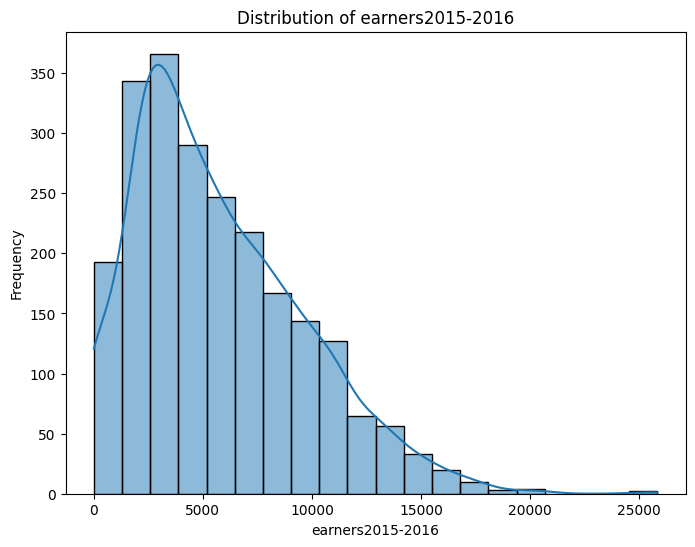

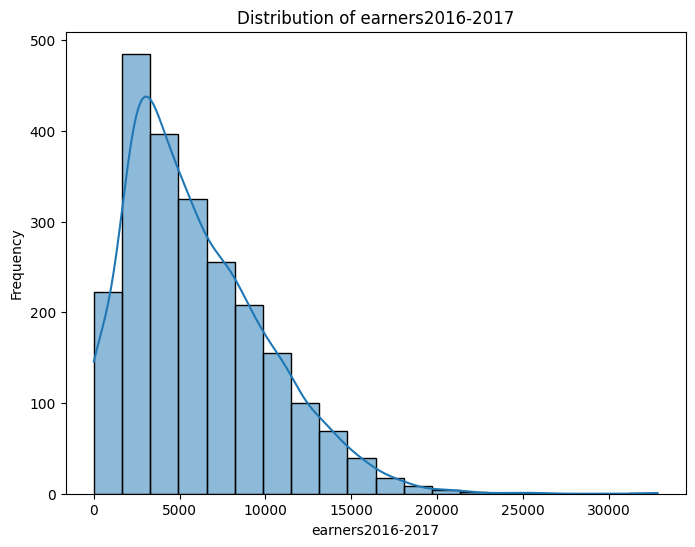

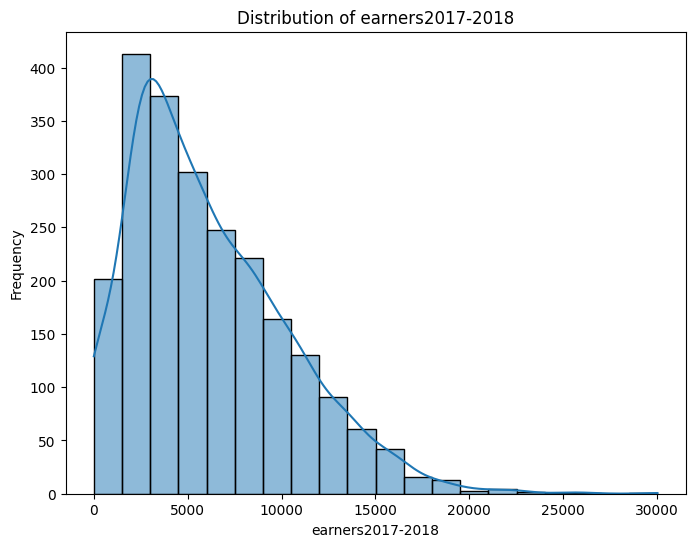

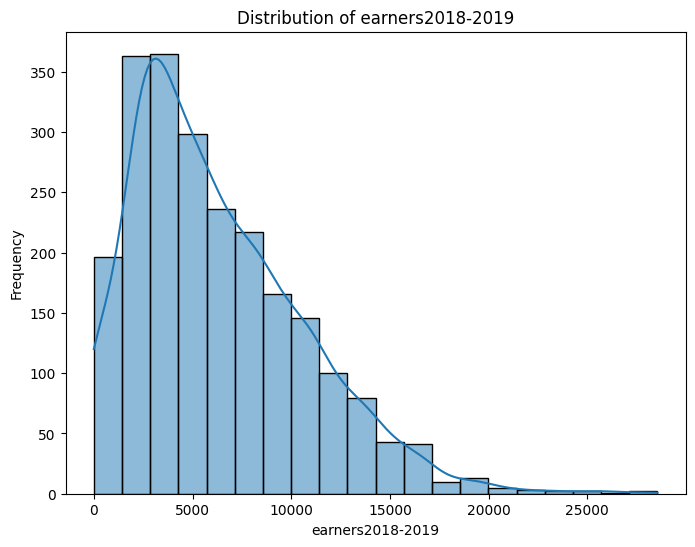

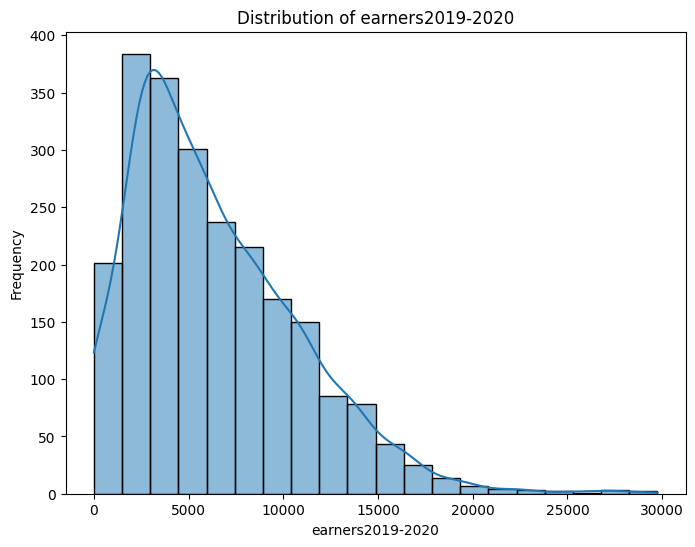

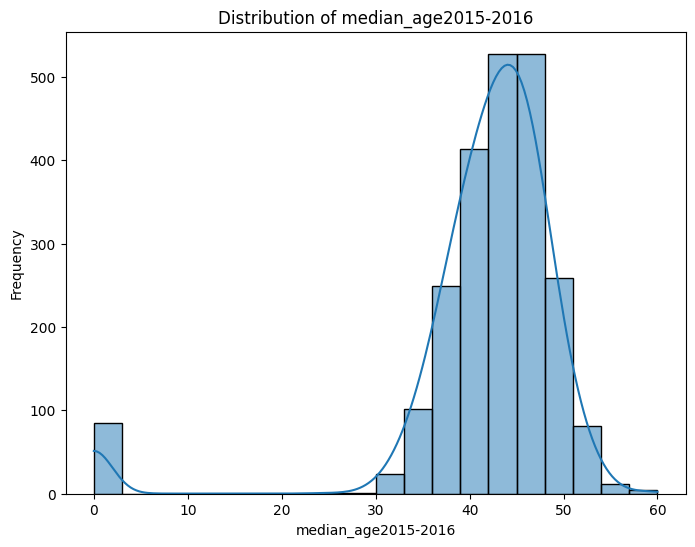

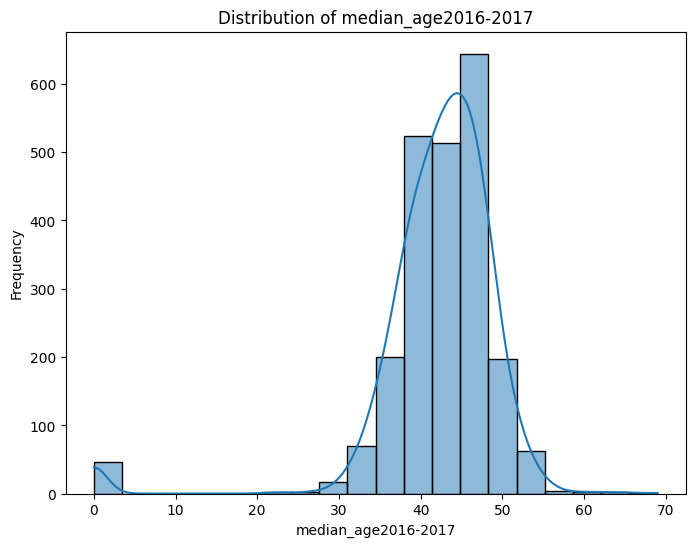

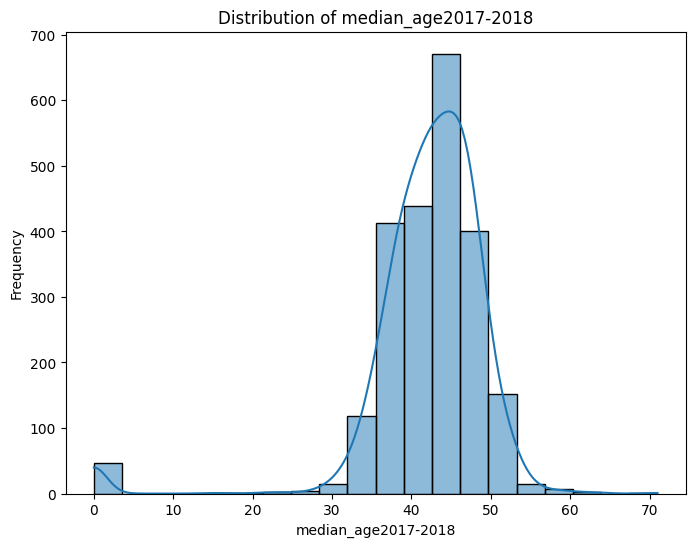

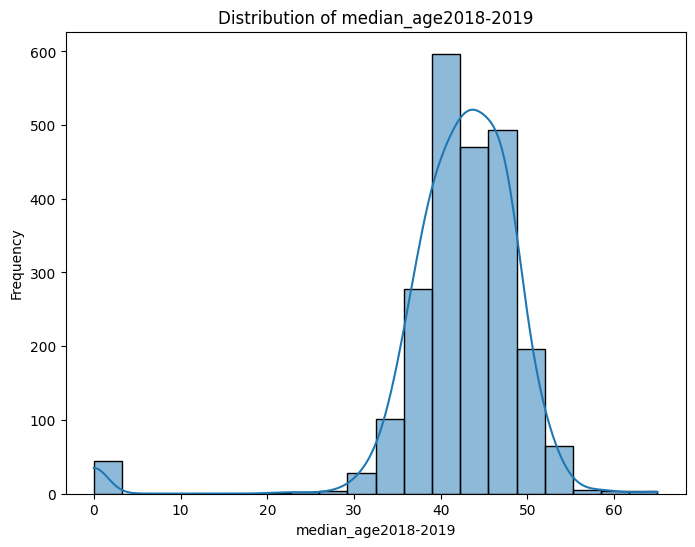

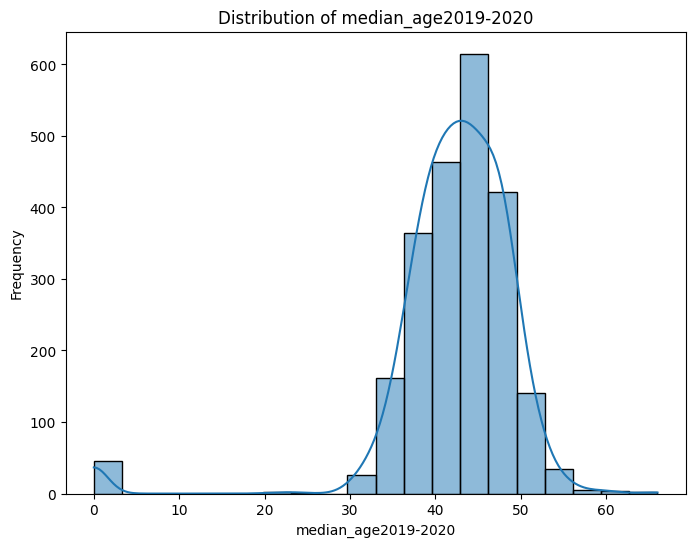

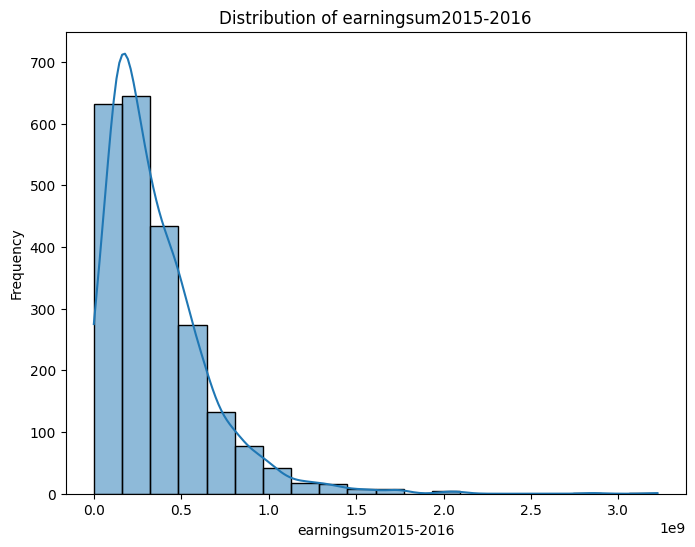

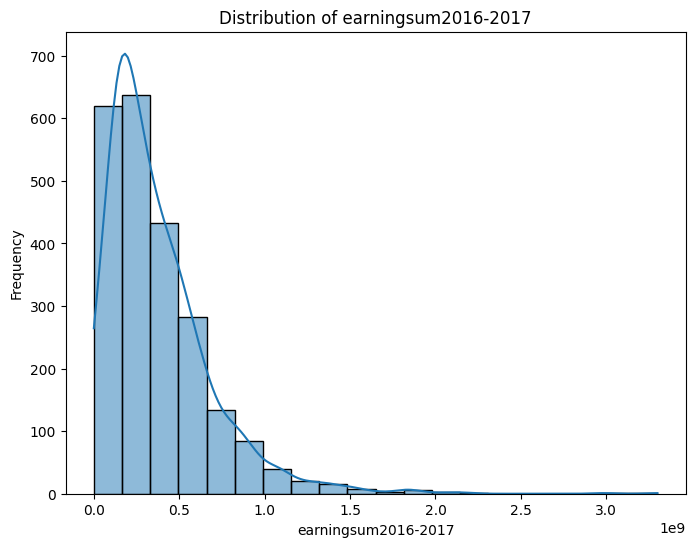

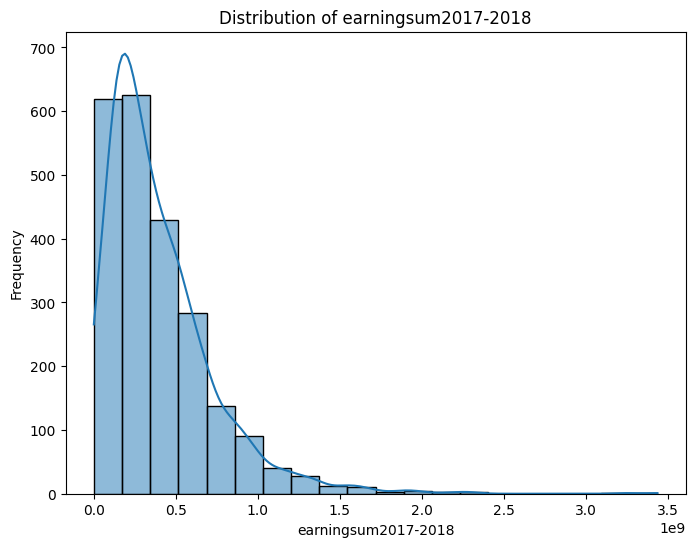

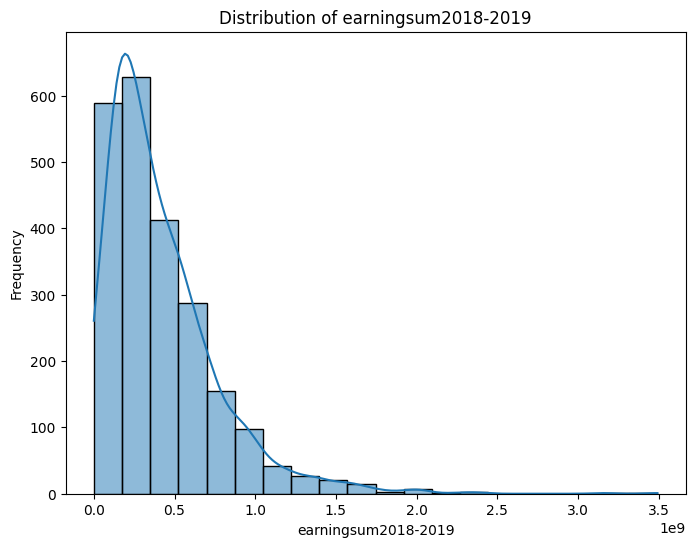

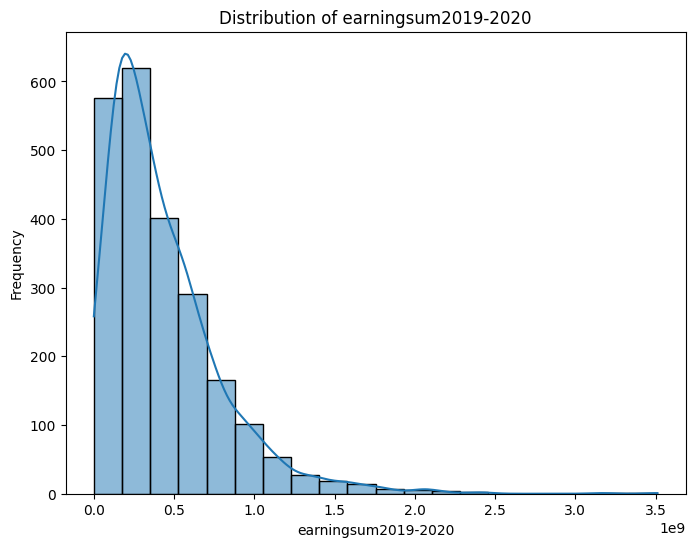

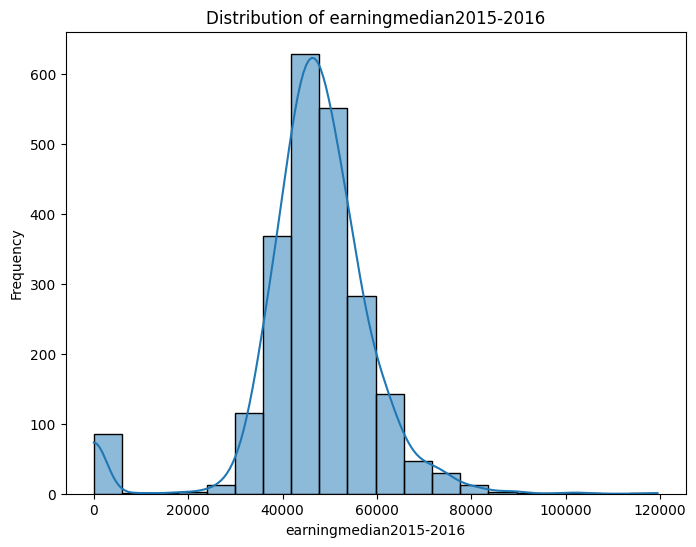

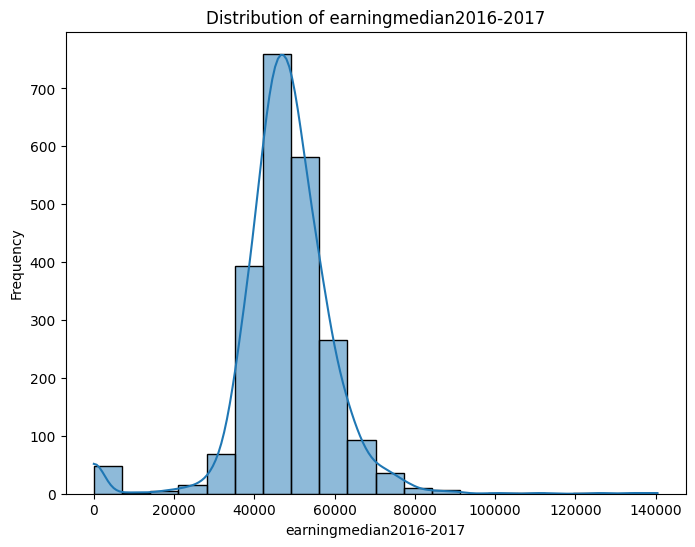

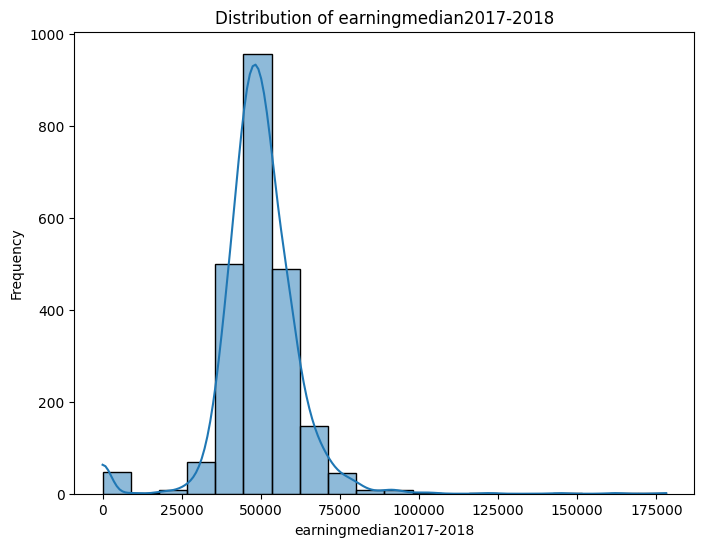

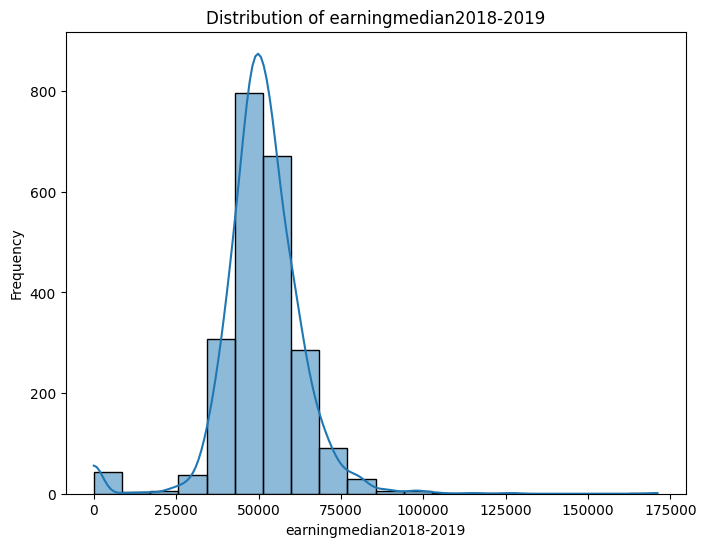

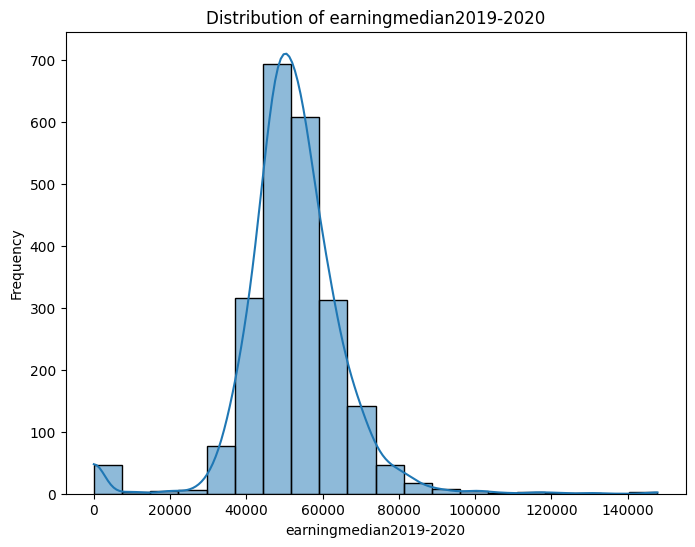

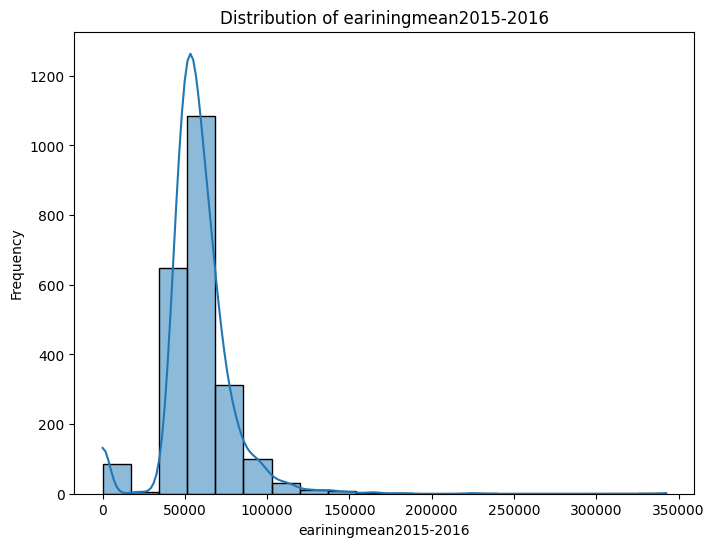

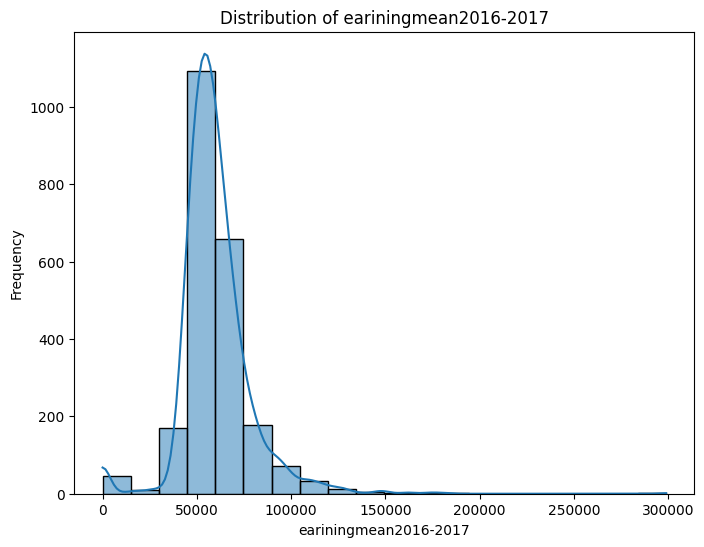

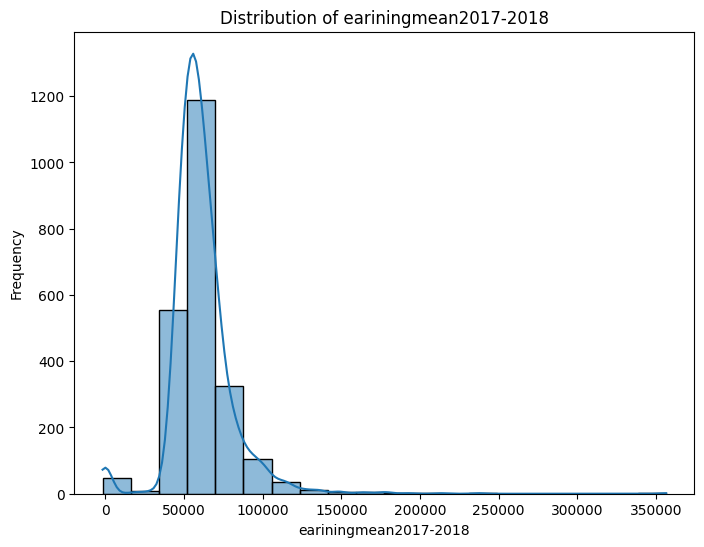

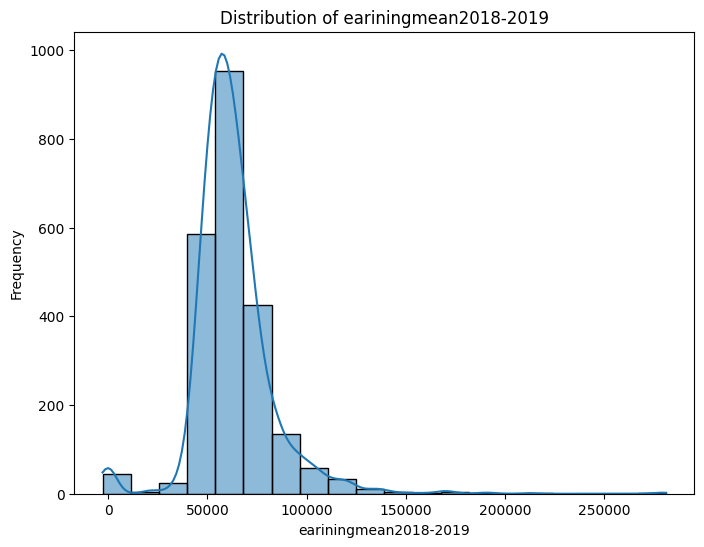

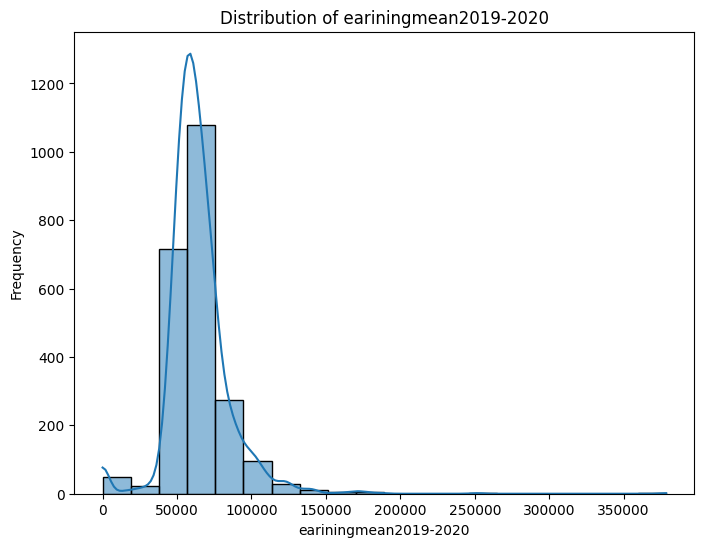

In [36]:
for col in earning_numericals:
    plot_distribution(earnings_sa2, col)

- AFTER REMOVAL

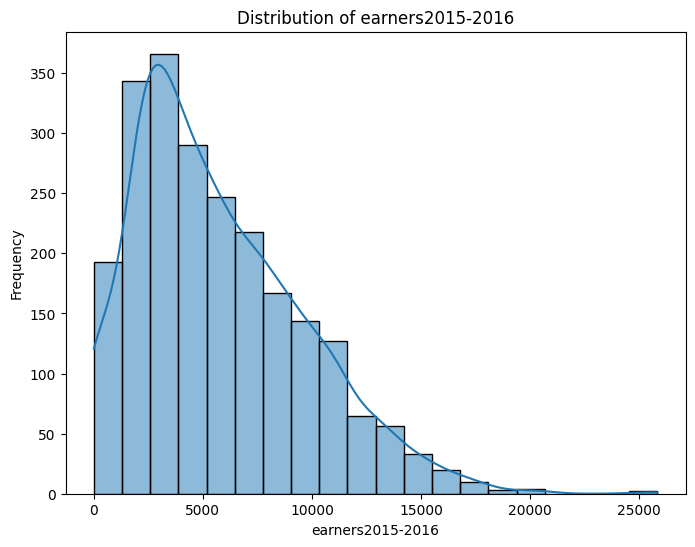

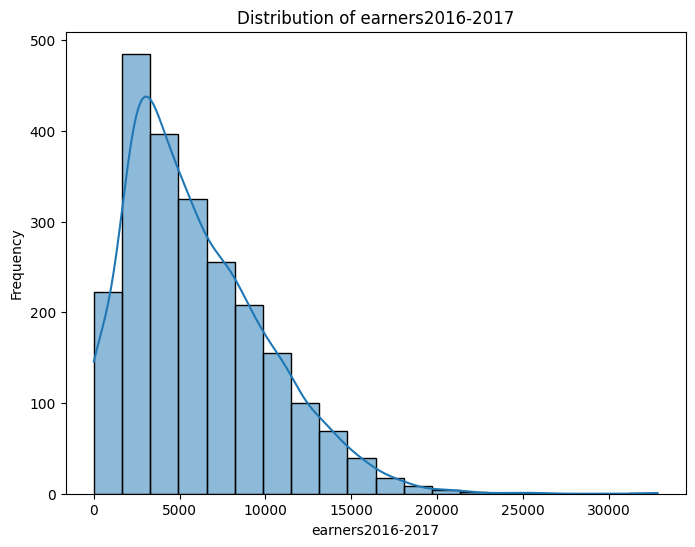

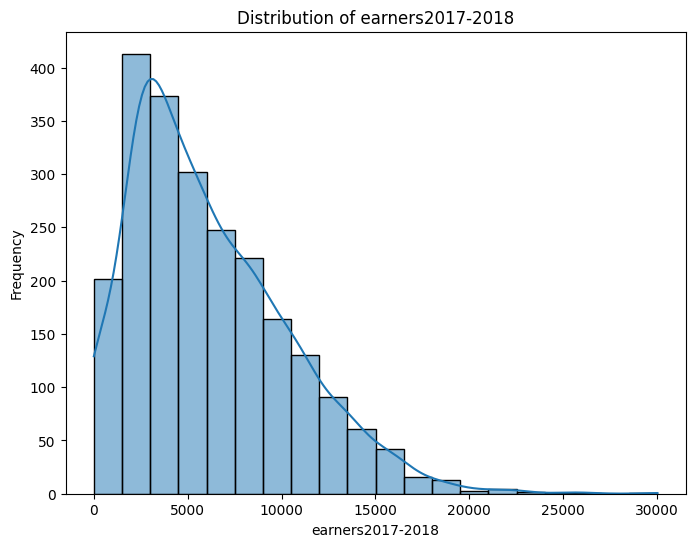

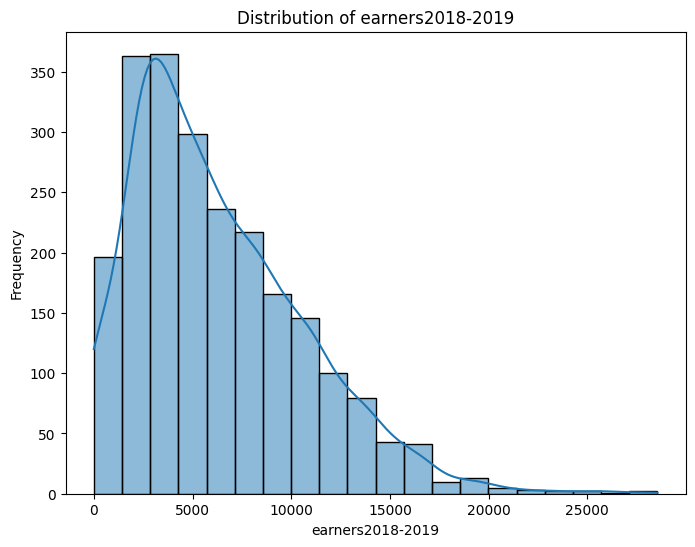

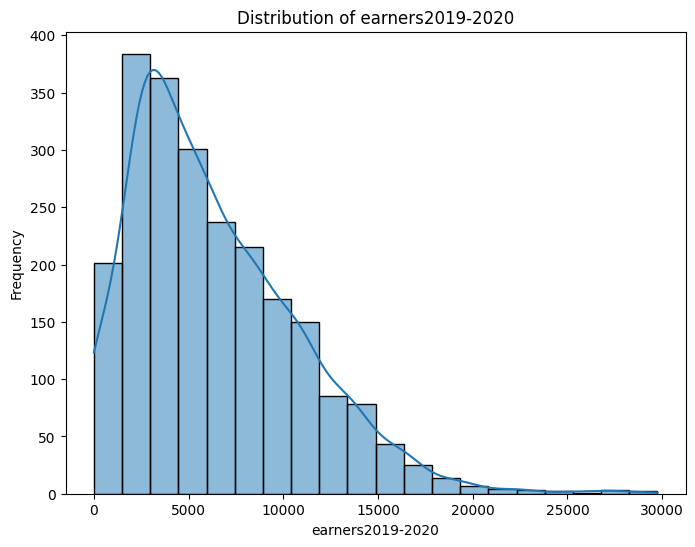

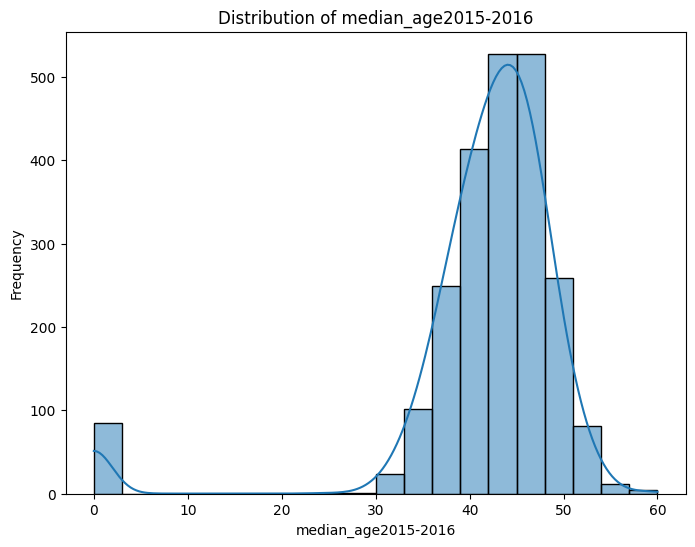

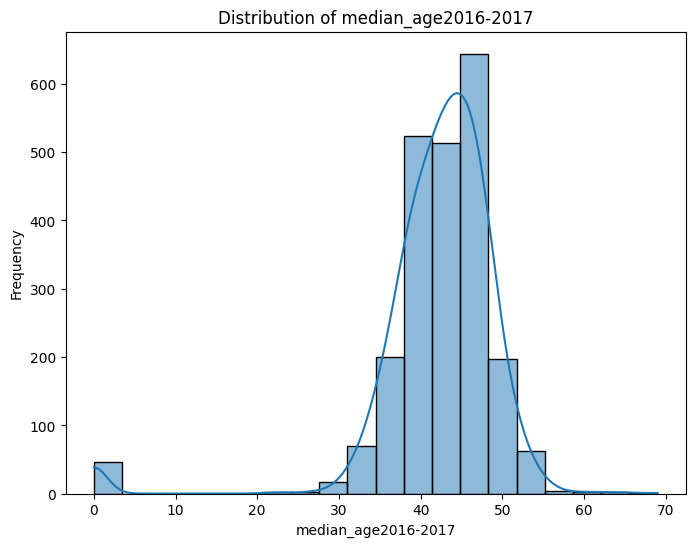

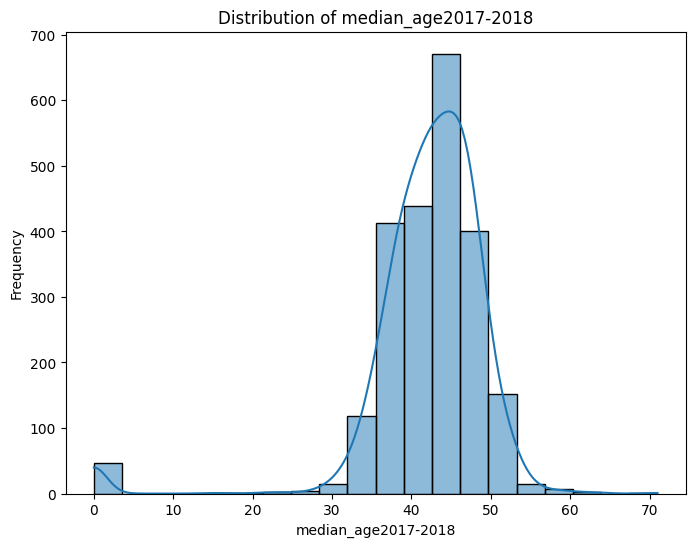

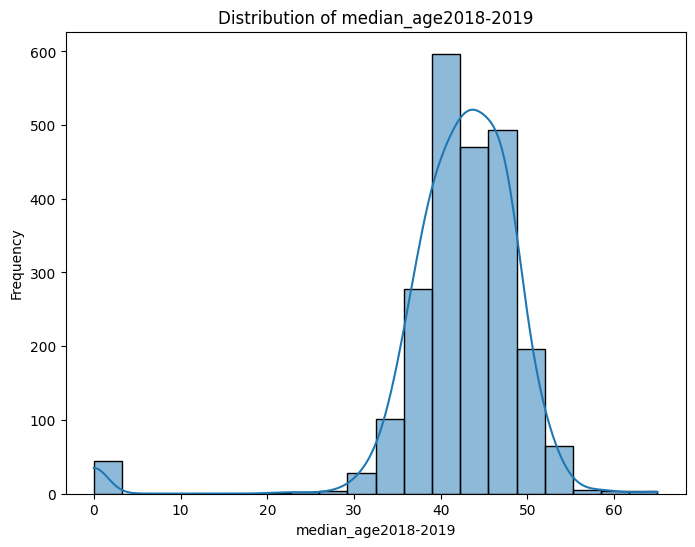

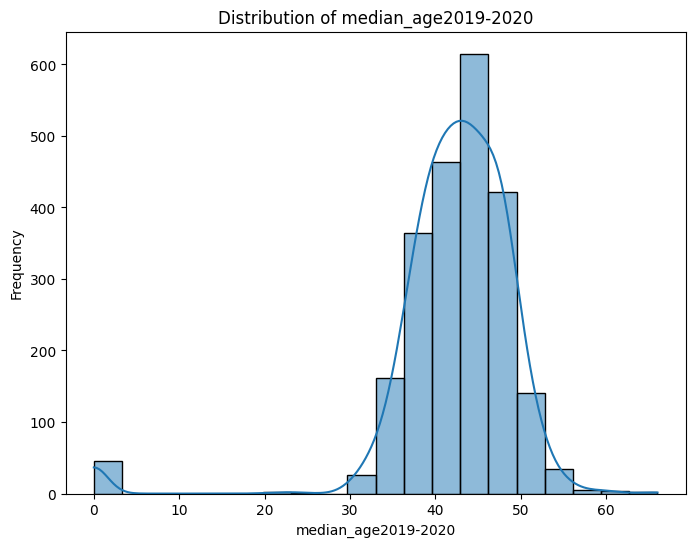

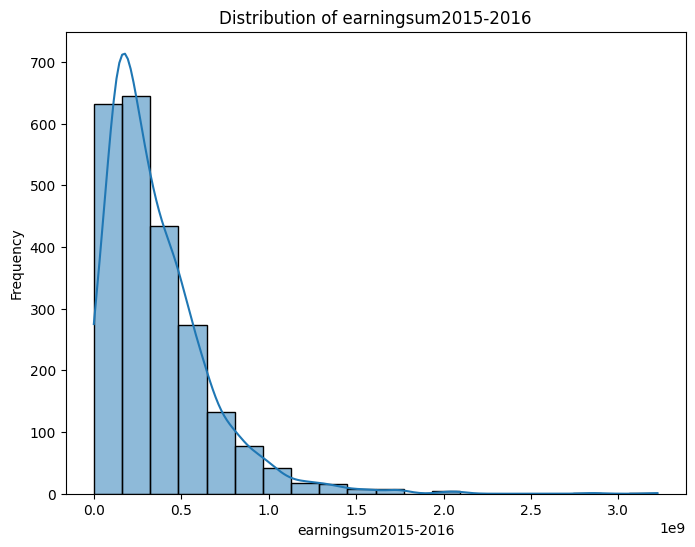

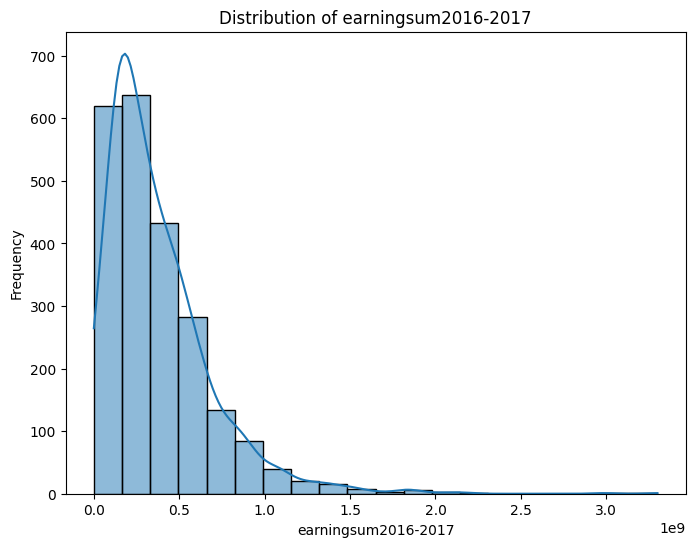

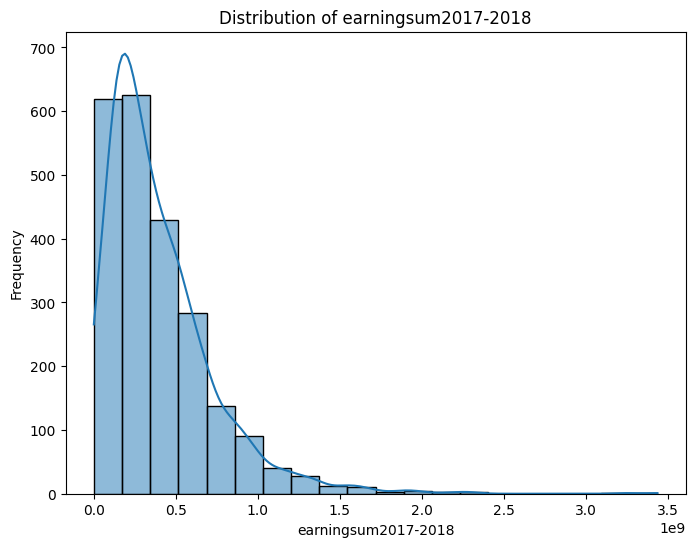

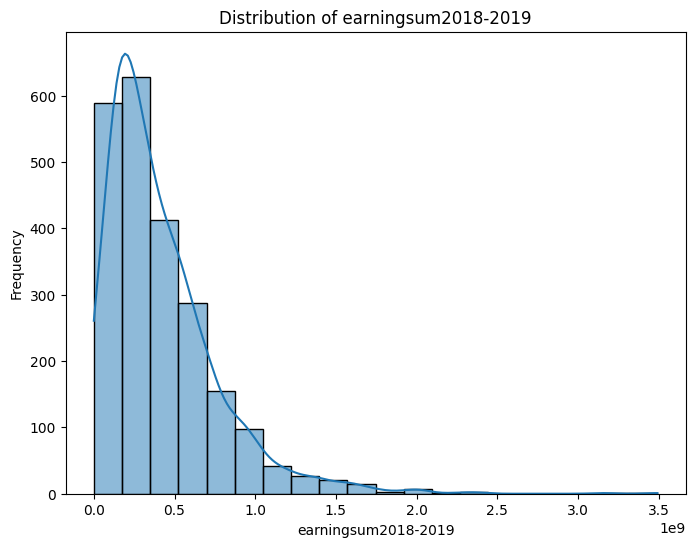

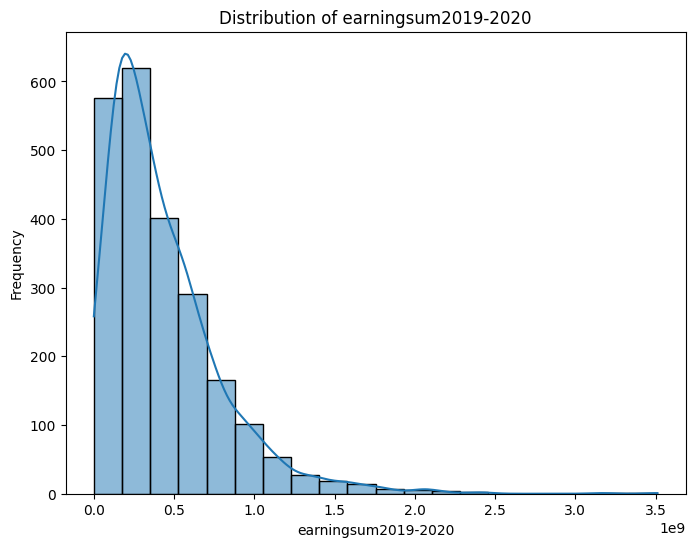

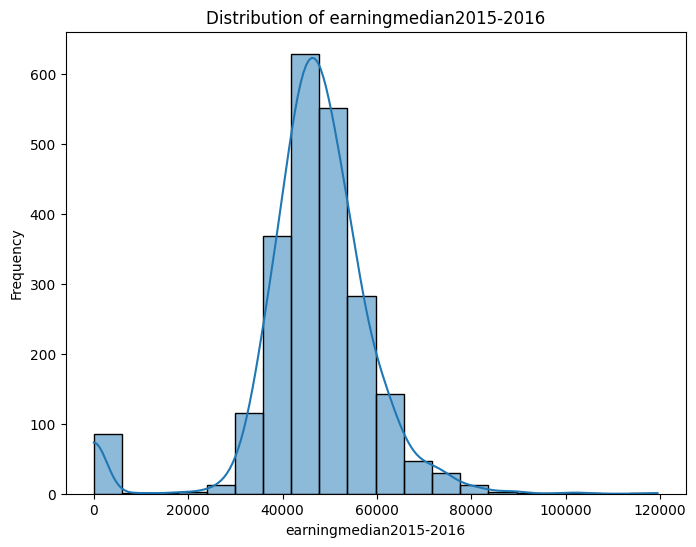

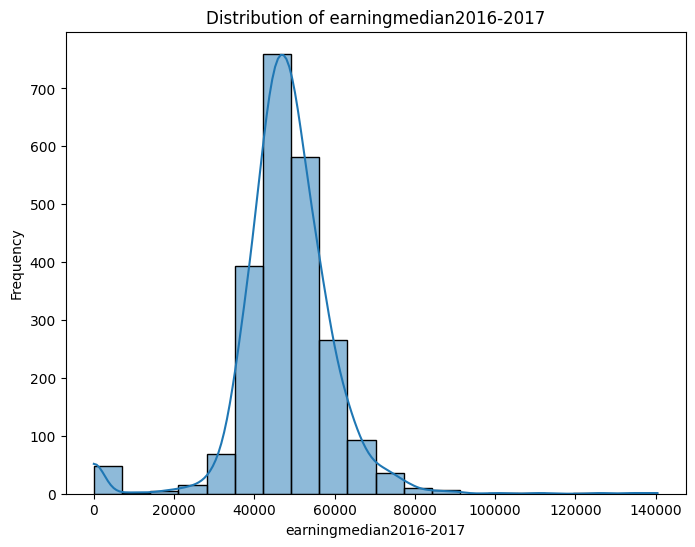

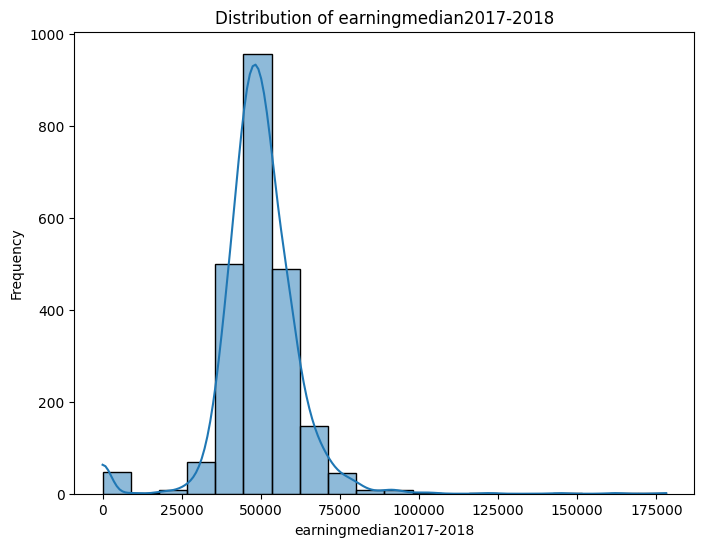

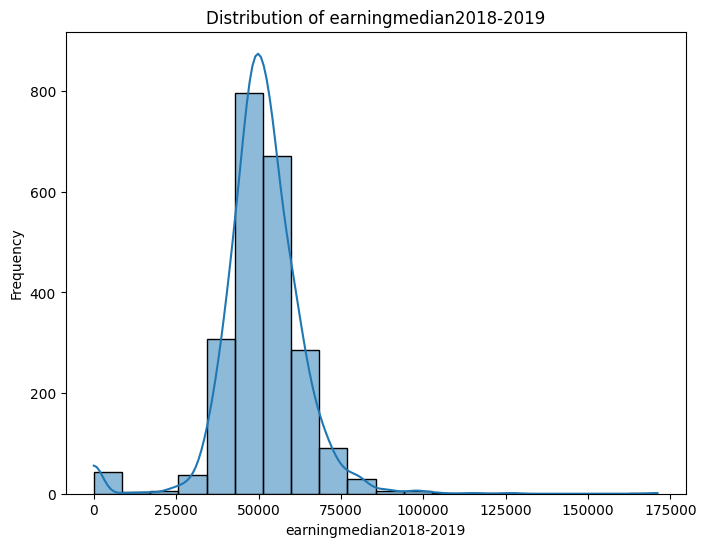

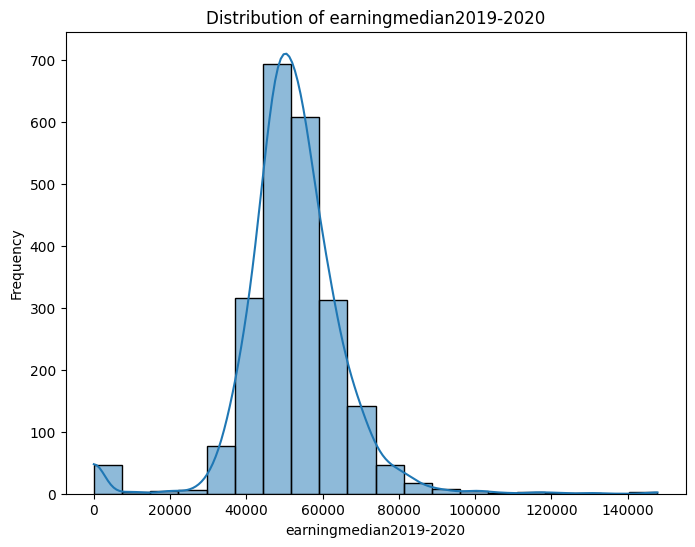

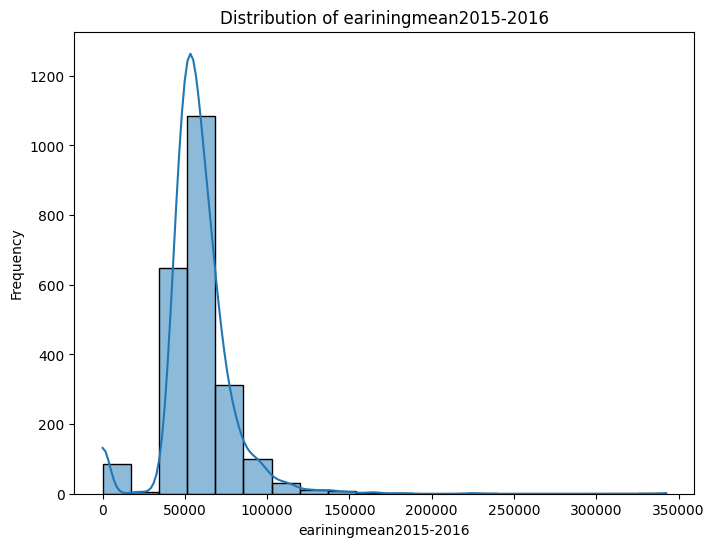

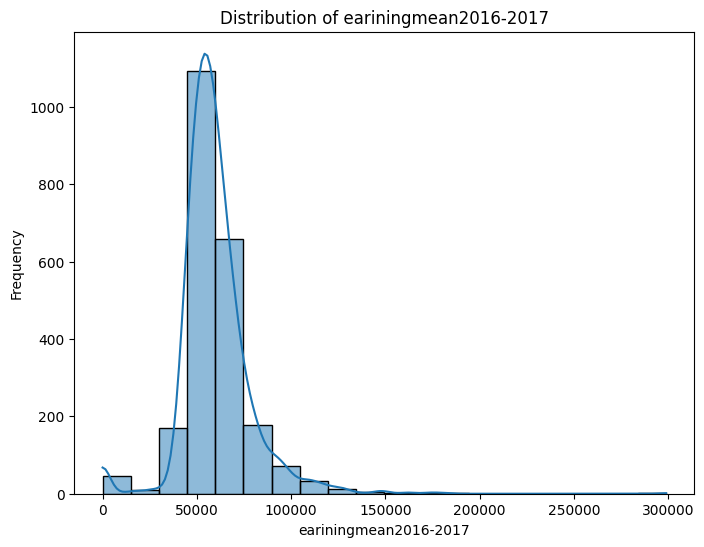

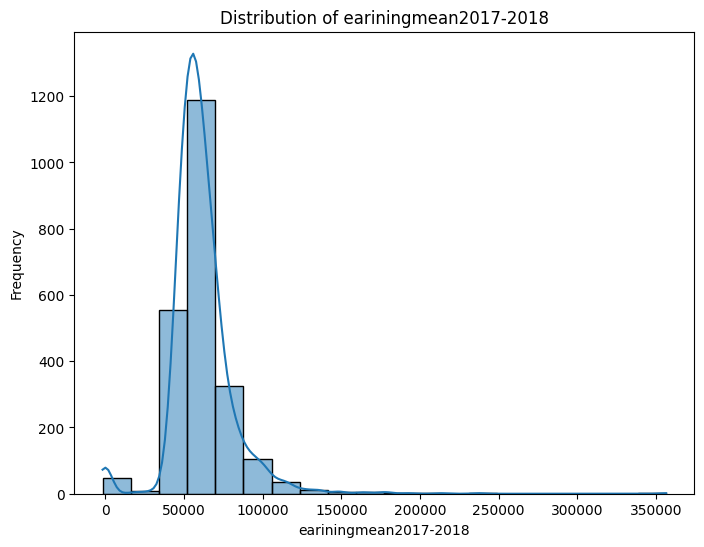

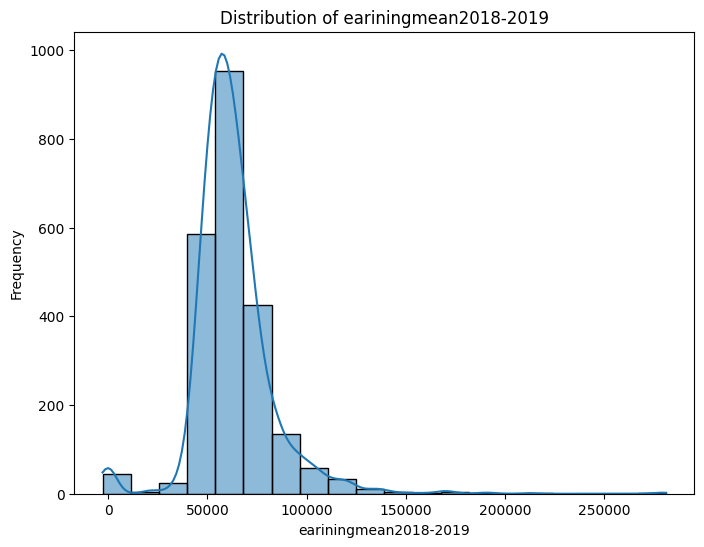

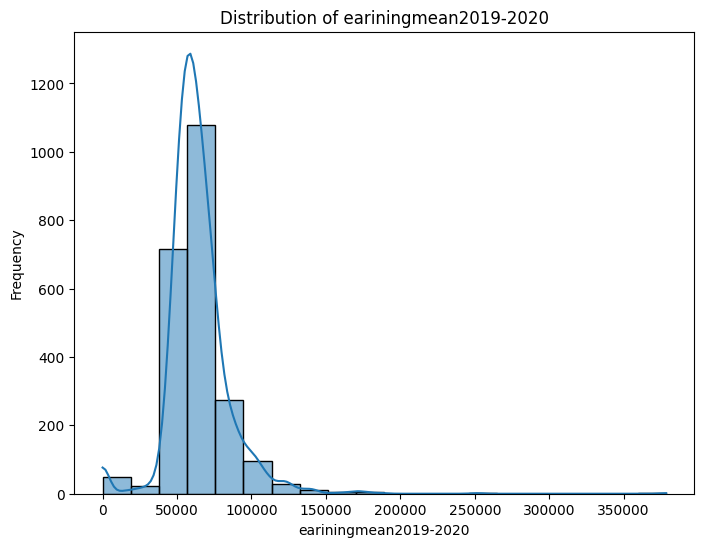

In [37]:
# Go columns wise first
for col in earning_numericals:
    # Calculate the outliers per dataset
    # calculate IQR for column A
    Q1 = earnings_sa2[col].quantile(0.25)
    Q3 = earnings_sa2[col].quantile(0.75)
    IQR = Q3 - Q1

    # identify outliers
    threshold = 1.5
    curr_df = earnings_sa2[(earnings_sa2[col] >= Q1 - threshold * IQR) | (earnings_sa2[col] <= Q3 + threshold * IQR)]
    plot_distribution(curr_df, col)

- Shape more or less stays the same so we can retain the outliers

### MALE POPULATION

In [38]:
population_male

state_name     sa2_code  \
1                  New South Wales  101021007.0   
2                  New South Wales  101021008.0   
3                  New South Wales  101021009.0   
4                  New South Wales  101021010.0   
5                  New South Wales  101021012.0   
...                            ...          ...   
2467  Australian Capital Territory  801101139.0   
2468  Australian Capital Territory  801101145.0   
2469  Australian Capital Territory  801101146.0   
2470  Australian Capital Territory  801111140.0   
2471  Australian Capital Territory  801111141.0   

                             sa2_name  male_age0-4  male_age5-9  \
1                           Braidwood        120.0        158.0   
2                             Karabar        283.0        296.0   
3                          Queanbeyan        329.0        315.0   
4                   Queanbeyan - East        164.0        130.0   
5     Queanbeyan West - Jerrabomberra        426.0        474.0   
...                               ...          ...          ...   
2467                           Wright        135.0        120.0   
2468                  Molonglo - East          0.0          0.0   
2469                          Whitlam          0.0          0.0   
2470                 ACT - South West         25.0         37.0   
2471                          Namadgi         10.0          0.0   

      male_age10-14  male_age15-19  male_age20-24  male_age25-29  \
1             123.0           87.0           65.0           89.0   
2             316.0          251.0          292.0          331.0   
3             244.0          255.0          374.0          581.0   
4             124.0          106.0          165.0          276.0   
5             527.0          473.0          389.0          321.0   
...             ...            ...            ...            ...   
2467          103.0           62.0          138.0          236.0   
2468            0.0            0.0            0.0            0.0   
2469            0.0            0.0            0.0            1.0   
2470           14.0           20.0           15.0           24.0   
2471            5.0            3.0            1.0            3.0   

      male_age30-34  ...  male_age45-49  male_age50-54  male_age55-59  \
1             102.0  ...          156.0          183.0          178.0   
2             319.0  ...          288.0          277.0          294.0   
3             646.0  ...          403.0          350.0          340.0   
4             310.0  ...          167.0          180.0          180.0   
5             426.0  ...          488.0          543.0          514.0   
...             ...  ...            ...            ...            ...   
2467          259.0  ...          103.0           86.0           65.0   
2468            0.0  ...            0.0            0.0            3.0   
2469            0.0  ...            0.0            1.0            0.0   
2470           11.0  ...           19.0           18.0           17.0   
2471            0.0  ...            2.0            6.0            2.0   

      male_age60-64  male_age65-69  male_age70-74  male_age75-79  \
1             217.0          172.0          140.0          116.0   
2             247.0          194.0          173.0           89.0   
3             307.0          242.0          198.0          127.0   
4             159.0          106.0           94.0           60.0   
5             336.0          216.0          181.0           91.0   
...             ...            ...            ...            ...   
2467           29.0           37.0           21.0           12.0   
2468            0.0            0.0            0.0            0.0   
2469            0.0            0.0            0.0            0.0   
2470            8.0           11.0            8.0            0.0   
2471            5.0            2.0            2.0            0.0   

      male_age80-84  male_age85_and_over  total_males  
1              74.0                 41.

In [39]:
male_numericals = list(population_male.columns)[3:]

In [40]:
outlier_dict = {}
total_values = len(population_male)
# Go columns wise first
for col in male_numericals:
    # Calculate the outliers per dataset
    # calculate IQR for column A
    Q1 = population_male[col].quantile(0.25)
    Q3 = population_male[col].quantile(0.75)
    IQR = Q3 - Q1

    # identify outliers
    threshold = 1.5
    outliers_sa2_code_less = list(population_male[(population_male[col] < Q1 - threshold * IQR)][SA2_CODE])
    outliers_sa2_name_less = list(population_male[(population_male[col] < Q1 - threshold * IQR)][SA2_NAME])
    outliers_sa2_code_more = list(population_male[(population_male[col] > Q3 + threshold * IQR)][SA2_CODE])
    outliers_sa2_name_more = list(population_male[(population_male[col] > Q3 + threshold * IQR)][SA2_NAME])
    outlier_dict[col] = (outliers_sa2_code_less, outliers_sa2_name_less, round(len(outliers_sa2_name_less)/total_values, 2),
                         outliers_sa2_code_more, outliers_sa2_name_more, round(len(outliers_sa2_name_more)/total_values, 2), 
                         round((len(outliers_sa2_name_more)+len(outliers_sa2_name_less))/total_values, 2))
[x[6] for x in list(outlier_dict.values())]

[0.02,
 0.01,
 0.01,
 0.01,
 0.02,
 0.03,
 0.03,
 0.01,
 0.01,
 0.0,
 0.0,
 0.0,
 0.01,
 0.01,
 0.02,
 0.02,
 0.03,
 0.03,
 0.0]

- Our percentages here are small, but we have to check if the distirbutions match

- BEFORE REMOVAL

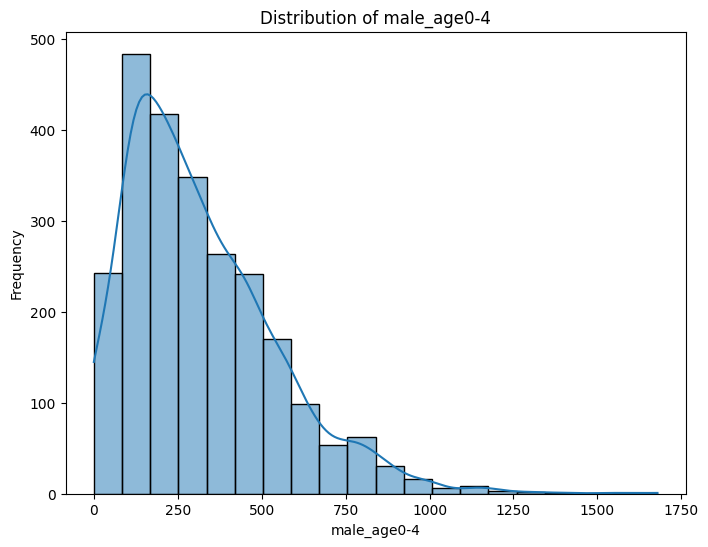

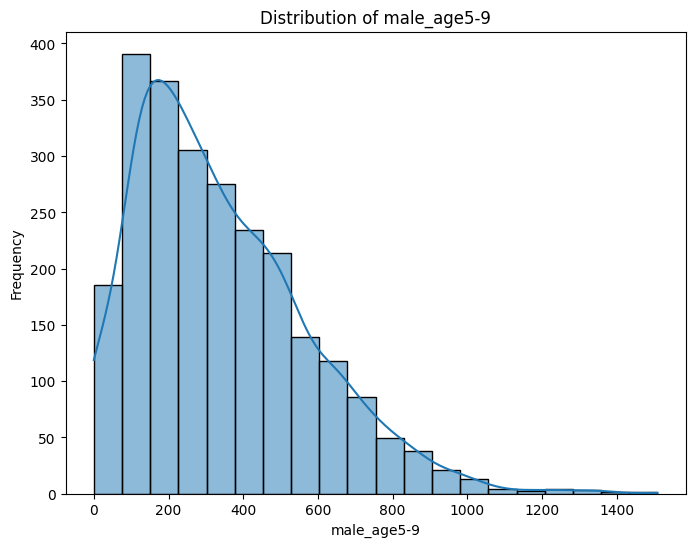

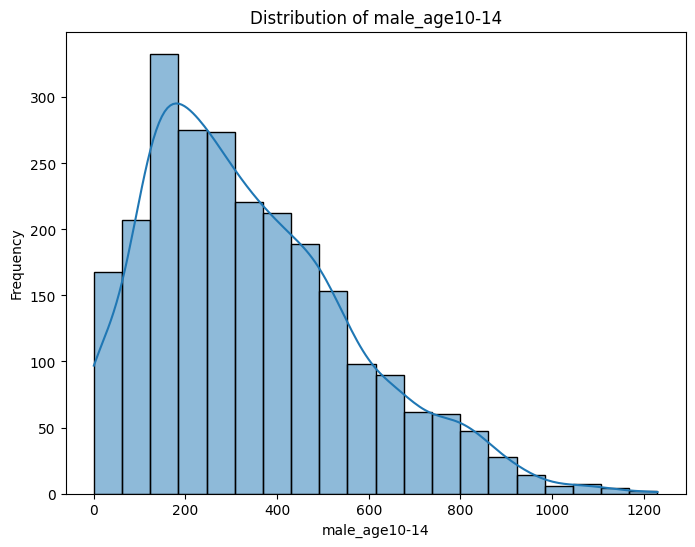

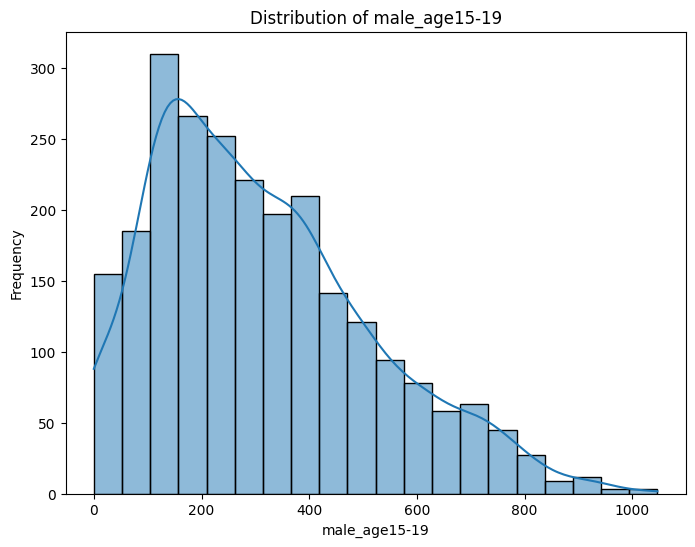

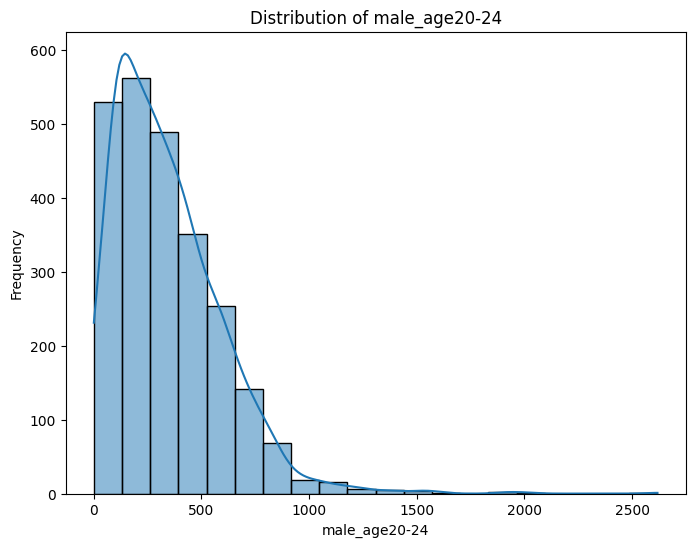

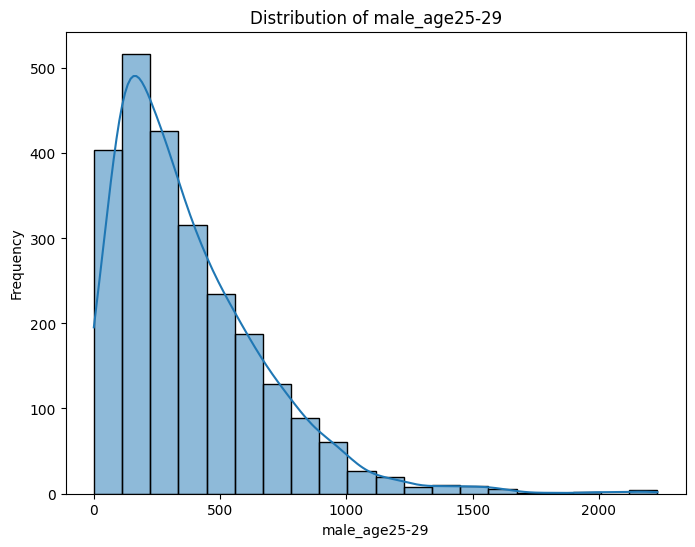

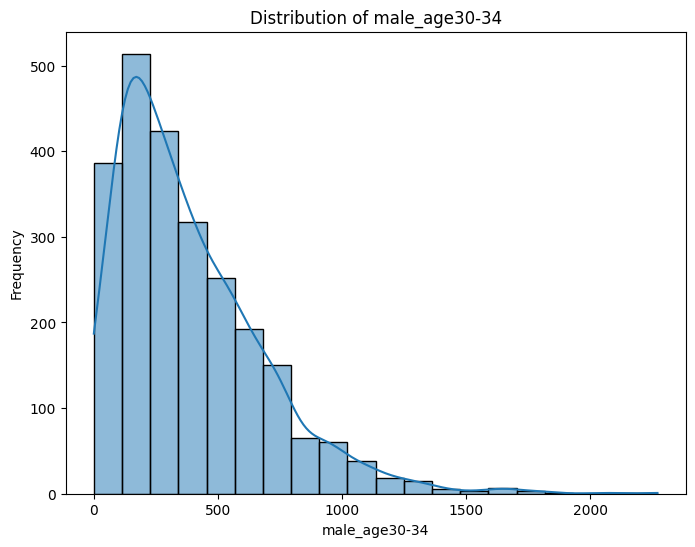

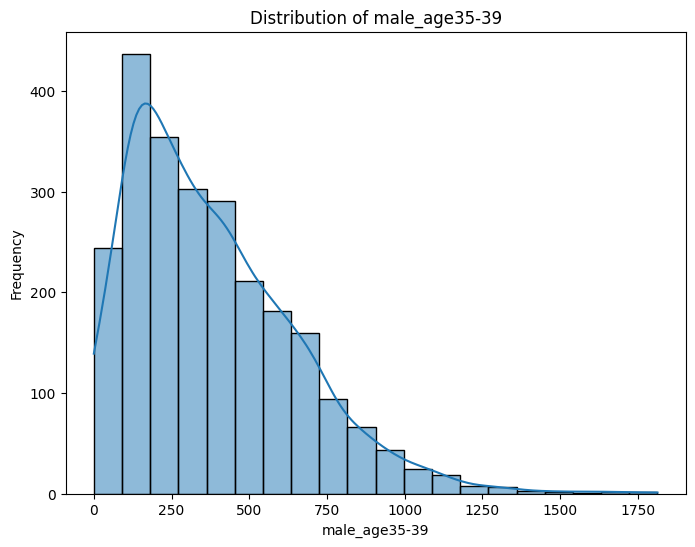

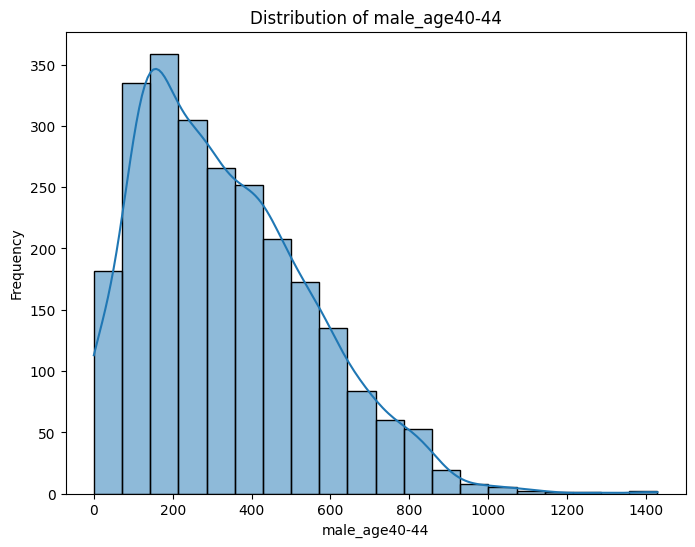

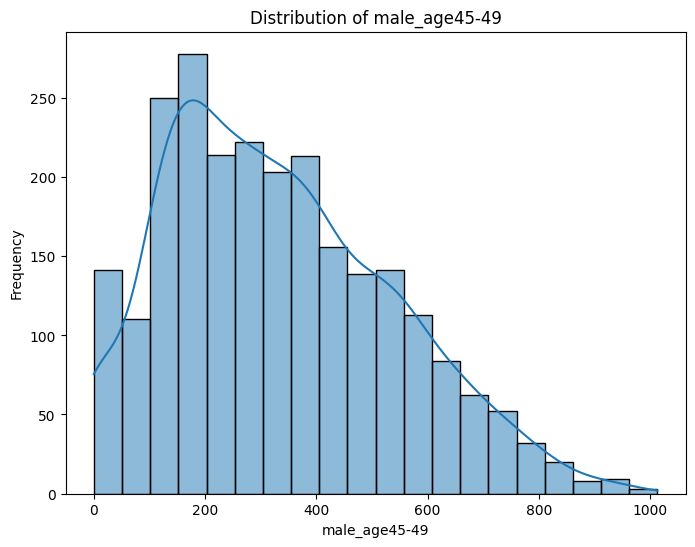

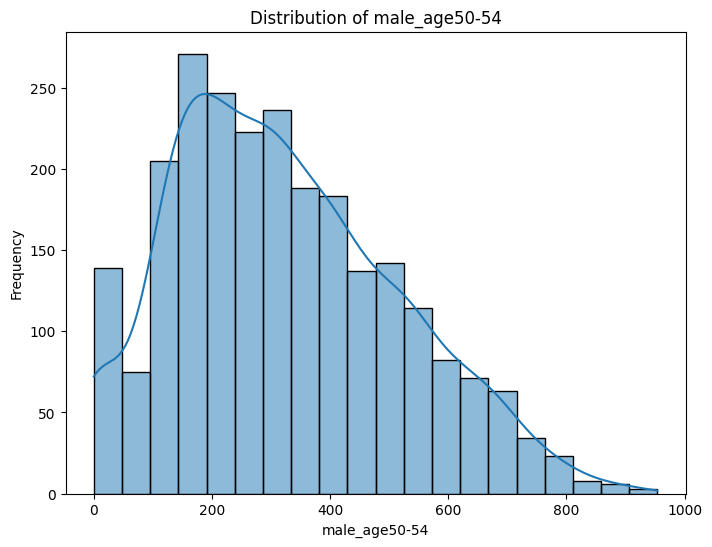

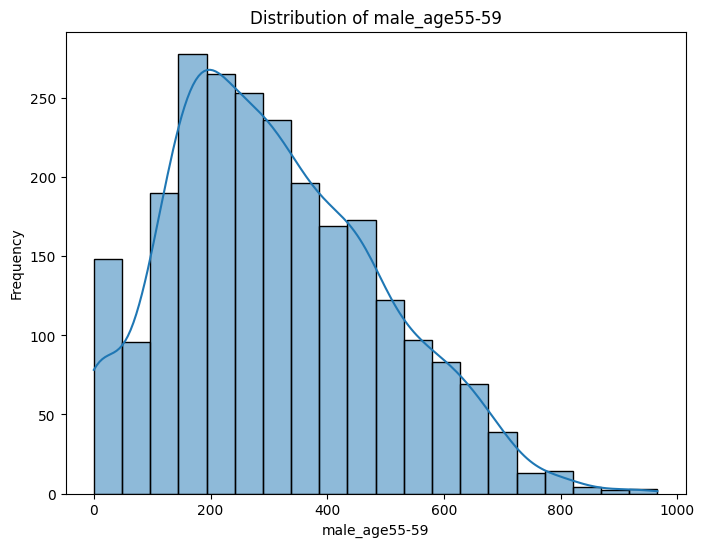

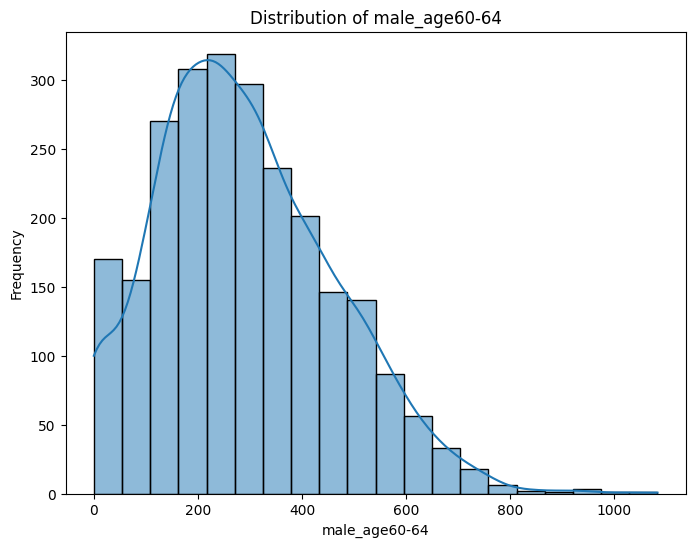

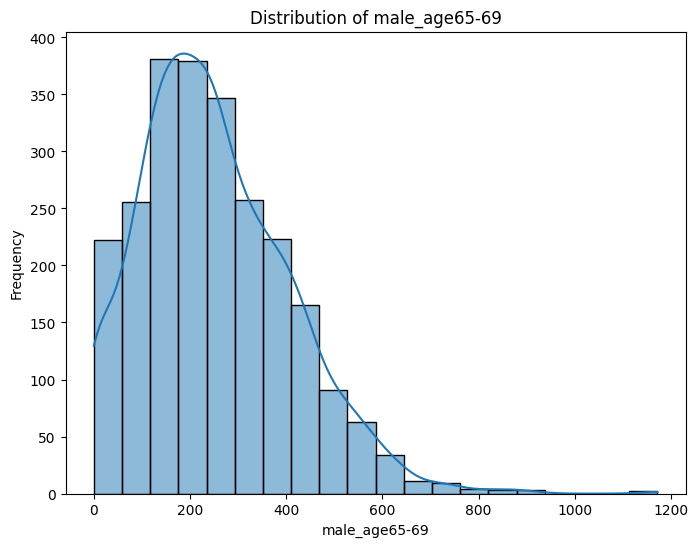

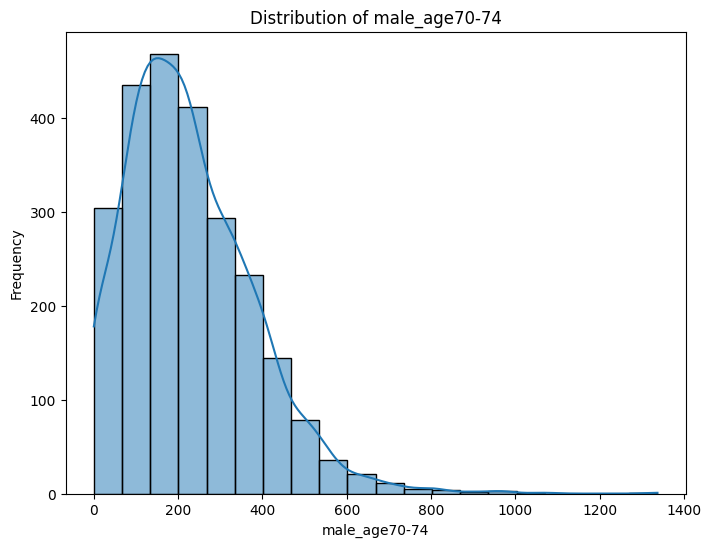

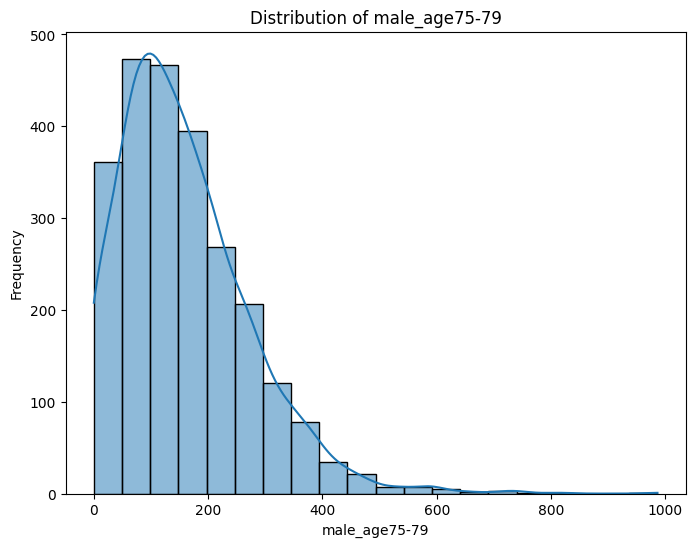

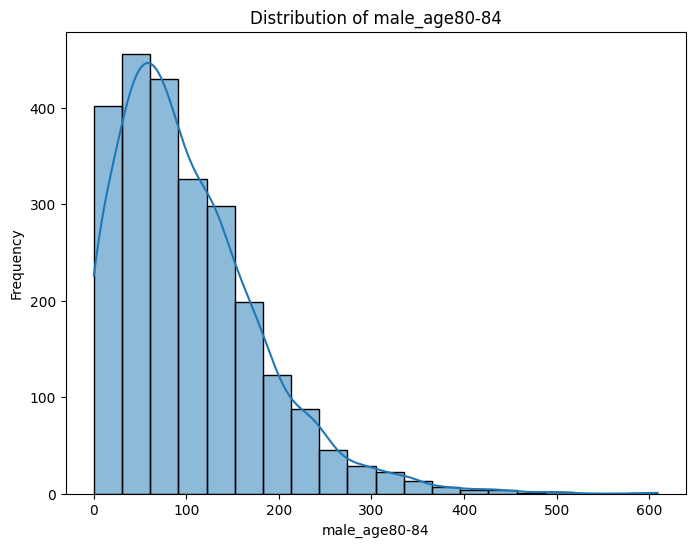

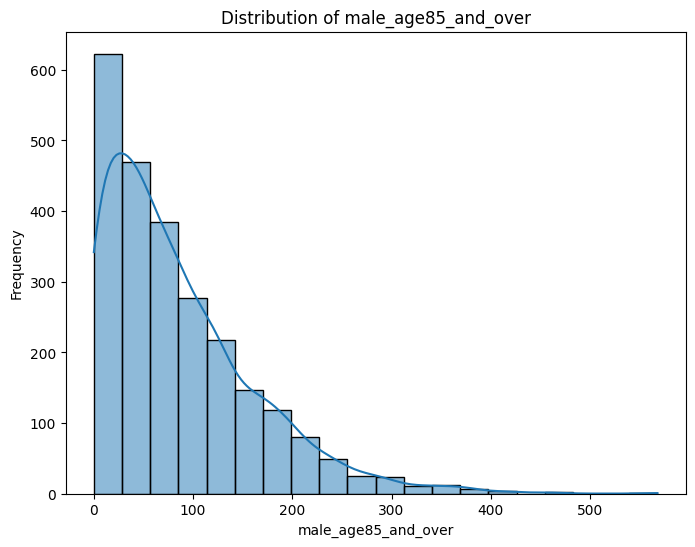

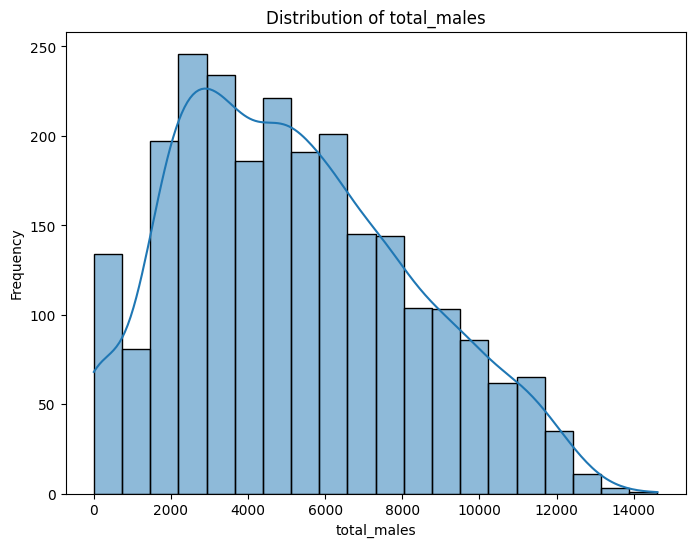

In [41]:
for col in male_numericals:
    plot_distribution(population_male, col)

- AFTER REMOVAL

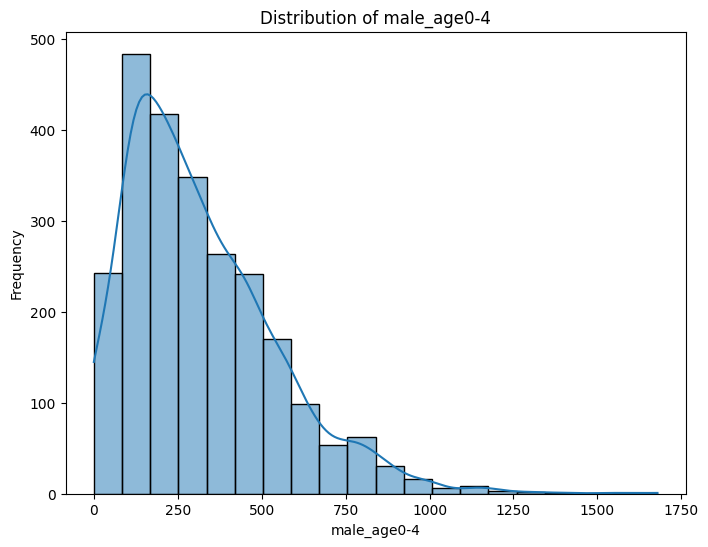

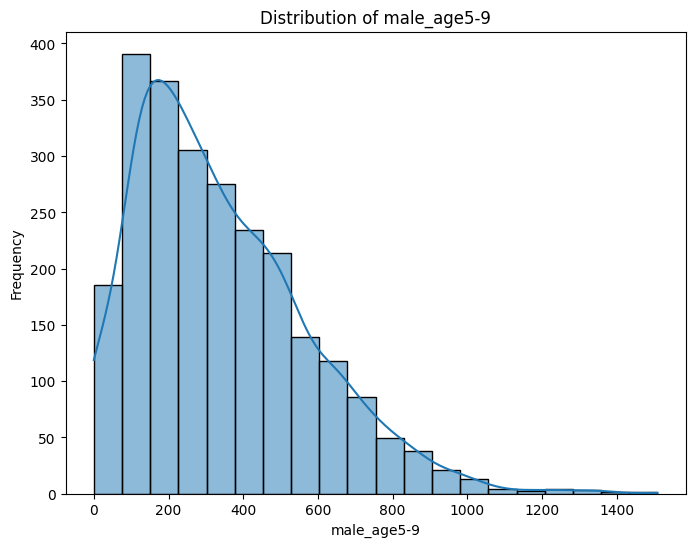

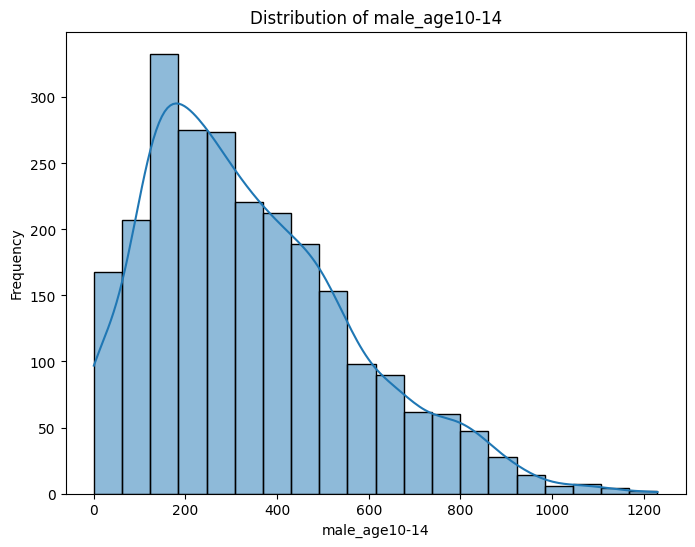

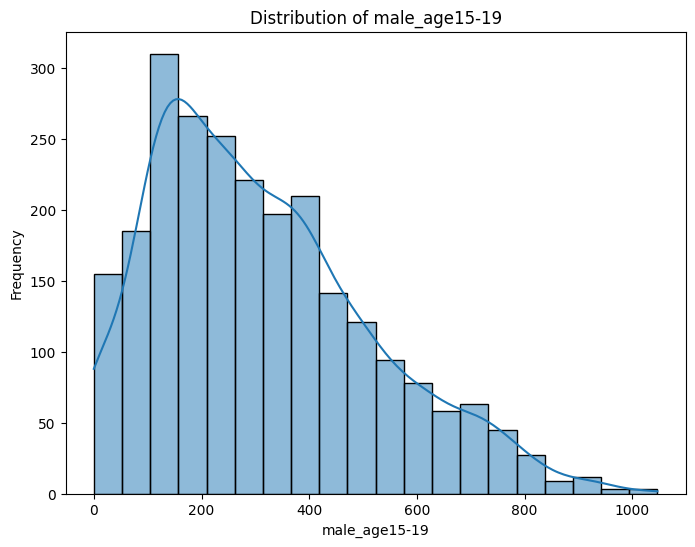

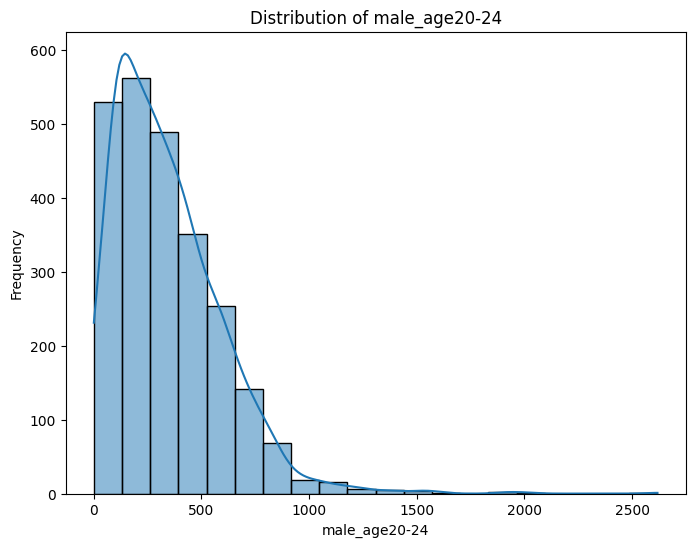

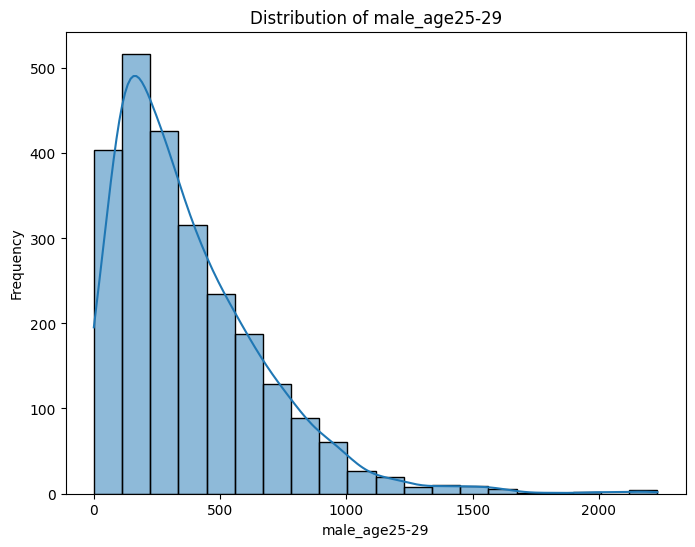

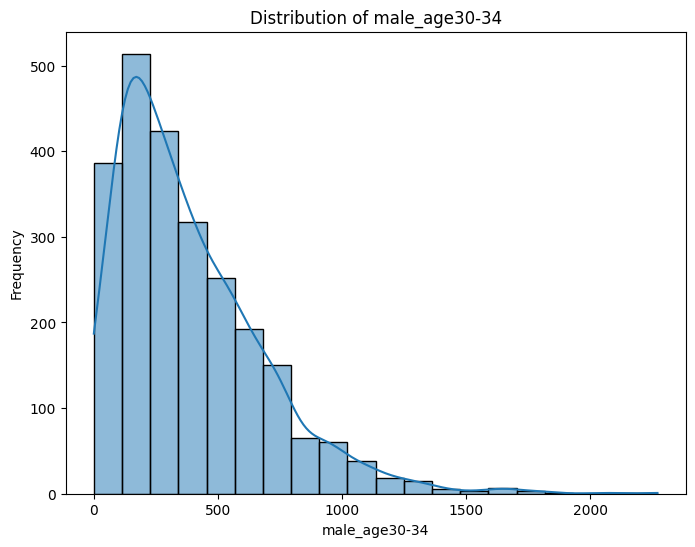

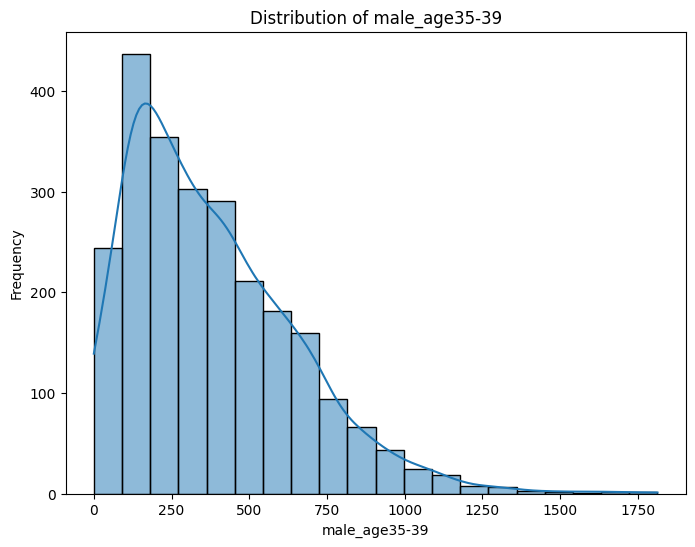

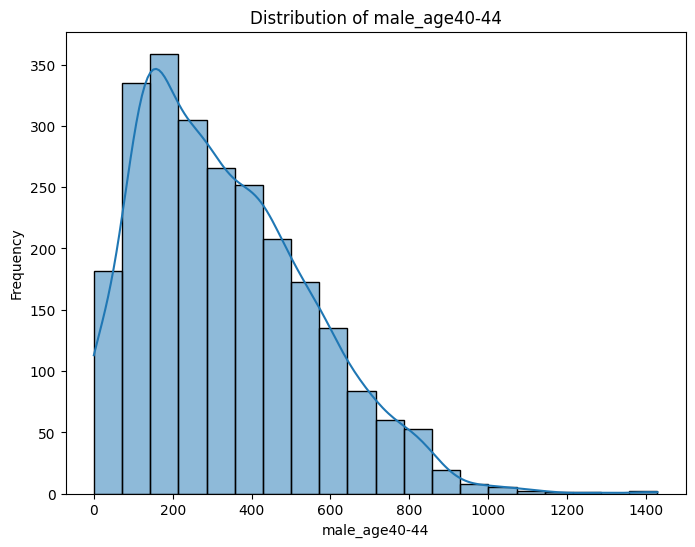

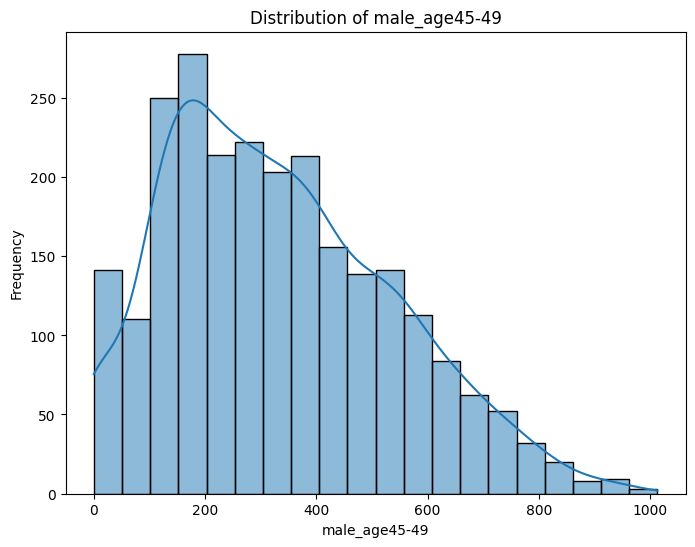

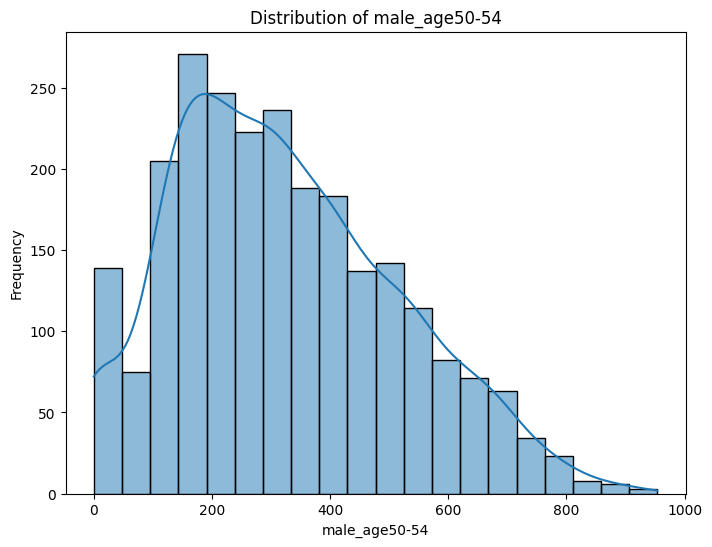

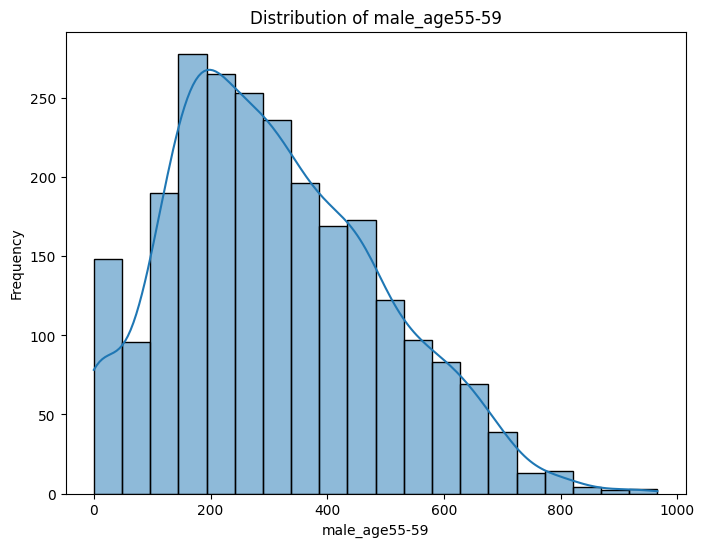

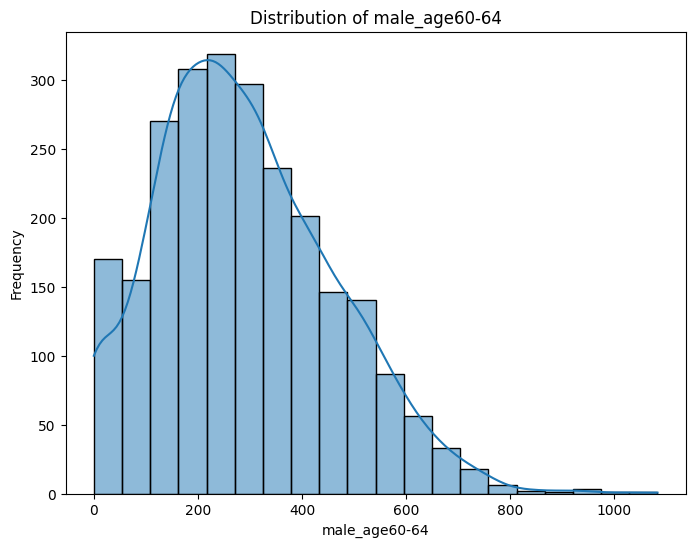

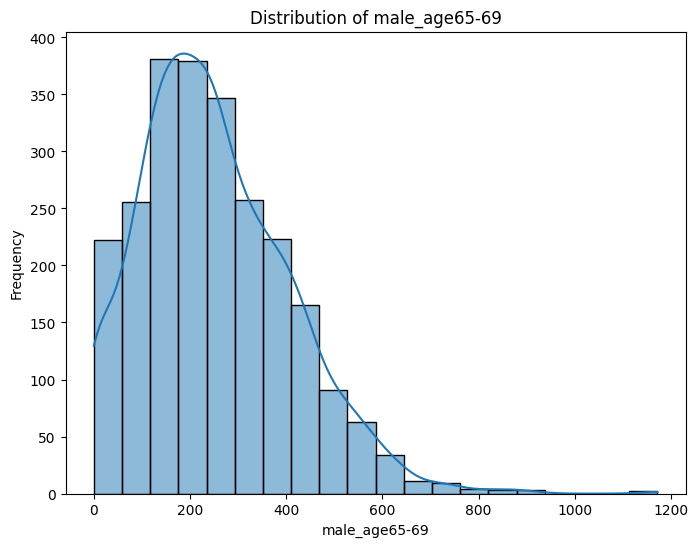

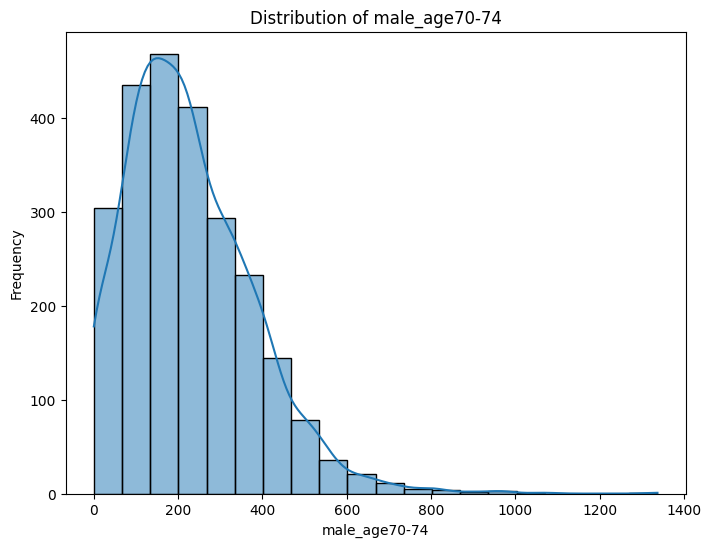

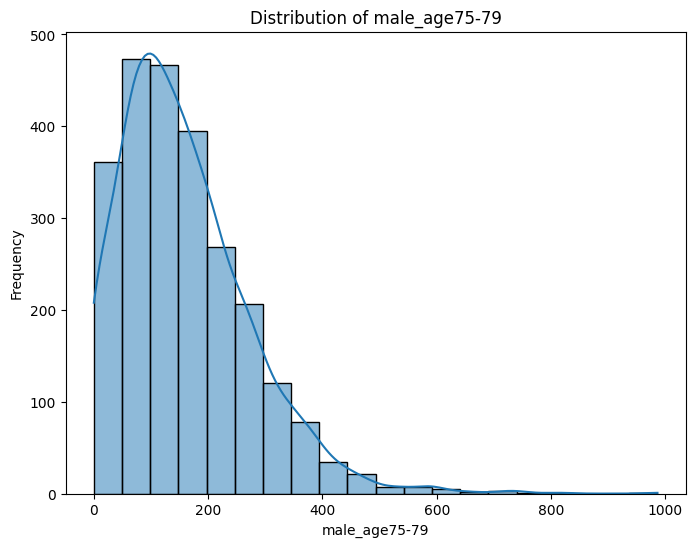

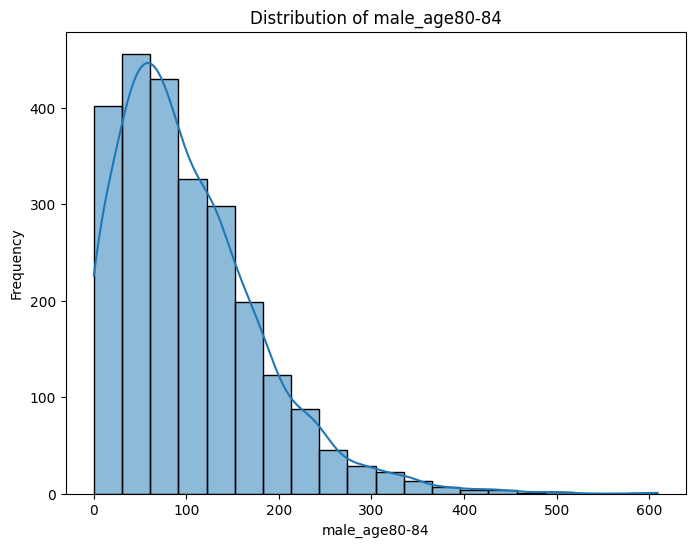

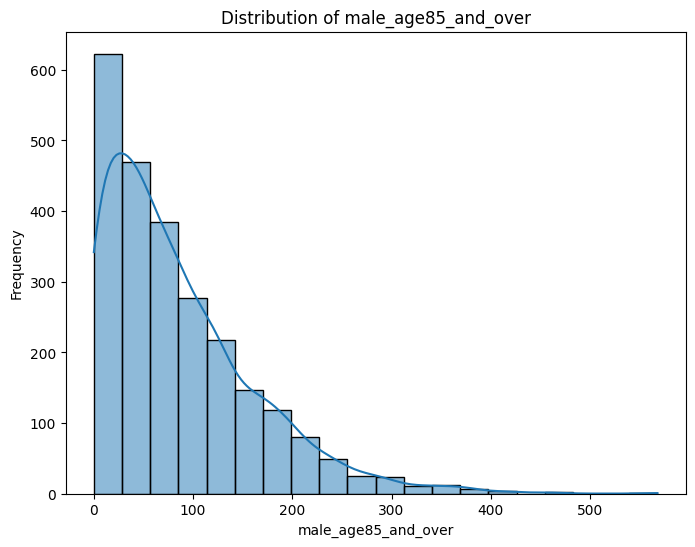

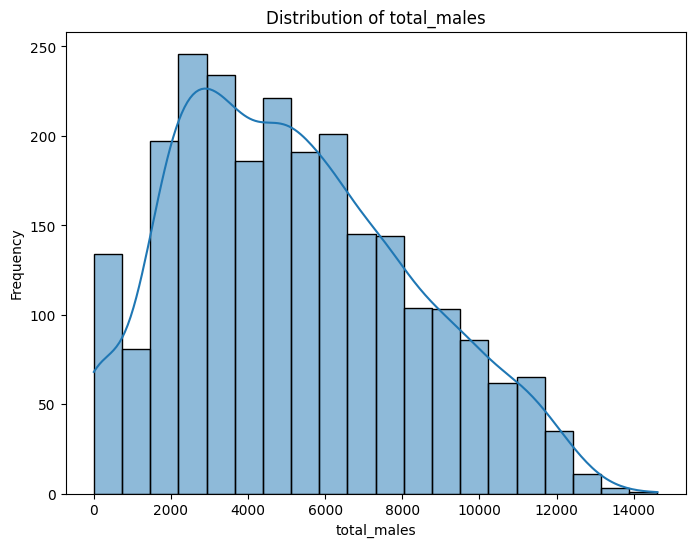

In [42]:
# Go columns wise first
for col in male_numericals:
    # Calculate the outliers per dataset
    # calculate IQR for column A
    Q1 = population_male[col].quantile(0.25)
    Q3 = population_male[col].quantile(0.75)
    IQR = Q3 - Q1

    # identify outliers
    threshold = 1.5
    curr_df = population_male[(population_male[col] >= Q1 - threshold * IQR) | (population_male[col] <= Q3 + threshold * IQR)]
    plot_distribution(curr_df, col)

- Distribution stays the same, so we don't nee to remove outliers

### FEMALE POPULATION

In [43]:
population_female

state_name     sa2_code  \
1                  New South Wales  101021007.0   
2                  New South Wales  101021008.0   
3                  New South Wales  101021009.0   
4                  New South Wales  101021010.0   
5                  New South Wales  101021012.0   
...                            ...          ...   
2467  Australian Capital Territory  801101139.0   
2468  Australian Capital Territory  801101145.0   
2469  Australian Capital Territory  801101146.0   
2470  Australian Capital Territory  801111140.0   
2471  Australian Capital Territory  801111141.0   

                             sa2_name  female_age0-4  female_age5-9  \
1                           Braidwood          100.0           95.0   
2                             Karabar          260.0          243.0   
3                          Queanbeyan          355.0          276.0   
4                   Queanbeyan - East          170.0          124.0   
5     Queanbeyan West - Jerrabomberra          444.0          452.0   
...                               ...            ...            ...   
2467                           Wright          154.0          154.0   
2468                  Molonglo - East            0.0            0.0   
2469                          Whitlam            3.0            0.0   
2470                 ACT - South West           20.0           21.0   
2471                          Namadgi            7.0            0.0   

      female_age10-14  female_age15-19  female_age20-24  female_age25-29  \
1               114.0             79.0             51.0             86.0   
2               259.0            249.0            240.0            311.0   
3               233.0            184.0            333.0            583.0   
4                92.0             84.0            186.0            296.0   
5               449.0            461.0            359.0            344.0   
...               ...              ...              ...              ...   
2467            114.0             79.0            157.0            259.0   
2468              0.0              0.0              0.0              0.0   
2469              0.0              0.0              0.0              2.0   
2470             20.0             15.0             14.0             24.0   
2471              0.0              3.0              0.0              2.0   

      female_age30-34  ...  female_age45-49  female_age50-54  female_age55-59  \
1               102.0  ...            144.0            169.0            184.0   
2               325.0  ...            268.0            313.0            286.0   
3               612.0  ...            293.0            332.0            324.0   
4               227.0  ...            130.0            183.0            135.0   
5               427.0  ...            544.0            571.0            473.0   
...               ...  ...              ...              ...              ...   
2467            294.0  ...            104.0             85.0             75.0   
2468              0.0  ...              0.0              0.0              0.0   
2469              2.0  ...              0.0              0.0              0.0   
2470             22.0  ...             18.0             13.0             11.0   
2471              2.0  ...              3.0              0.0              0.0   

      female_age60-64  female_age65-69  female_age70-74  female_age75-79  \
1               207.0            156.0            153.0            121.0   
2               269.0            218.0            147.0            127.0   
3               267.0            257.0            207.0            151.0   
4               136.0            102.0             78.0             62.0   
5               310.0            226.0            177.0            106.0   
...               ...              ...              ...              ...   
2467             53.0             32.0             21.0              6.0   
2468              0.0              0.0              0.0         

In [44]:
female_numericals = list(population_female.columns)[3:]

In [45]:
female_numericals

['female_age0-4',
 'female_age5-9',
 'female_age10-14',
 'female_age15-19',
 'female_age20-24',
 'female_age25-29',
 'female_age30-34',
 'female_age35-39',
 'female_age40-44',
 'female_age45-49',
 'female_age50-54',
 'female_age55-59',
 'female_age60-64',
 'female_age65-69',
 'female_age70-74',
 'female_age75-79',
 'female_age80-84',
 'female_age85_and_over',
 'total_females']

In [46]:
outlier_dict = {}
total_values = len(population_female)
# Go columns wise first
for col in female_numericals:
    # Calculate the outliers per dataset
    # calculate IQR for column A
    Q1 = population_female[col].quantile(0.25)
    Q3 = population_female[col].quantile(0.75)
    IQR = Q3 - Q1

    # identify outliers
    threshold = 1.5
    outliers_sa2_code_less = list(population_female[(population_female[col] < Q1 - threshold * IQR)][SA2_CODE])
    outliers_sa2_name_less = list(population_female[(population_female[col] < Q1 - threshold * IQR)][SA2_NAME])
    outliers_sa2_code_more = list(population_female[(population_female[col] > Q3 + threshold * IQR)][SA2_CODE])
    outliers_sa2_name_more = list(population_female[(population_female[col] > Q3 + threshold * IQR)][SA2_NAME])
    outlier_dict[col] = (outliers_sa2_code_less, outliers_sa2_name_less, round(len(outliers_sa2_name_less)/total_values, 2),
                         outliers_sa2_code_more, outliers_sa2_name_more, round(len(outliers_sa2_name_more)/total_values, 2), 
                         round((len(outliers_sa2_name_more)+len(outliers_sa2_name_less))/total_values, 2))
[x[6] for x in list(outlier_dict.values())]

[0.02,
 0.02,
 0.01,
 0.01,
 0.02,
 0.03,
 0.02,
 0.01,
 0.01,
 0.0,
 0.0,
 0.0,
 0.01,
 0.01,
 0.02,
 0.02,
 0.03,
 0.03,
 0.0]

- BEFORE REMOVAL

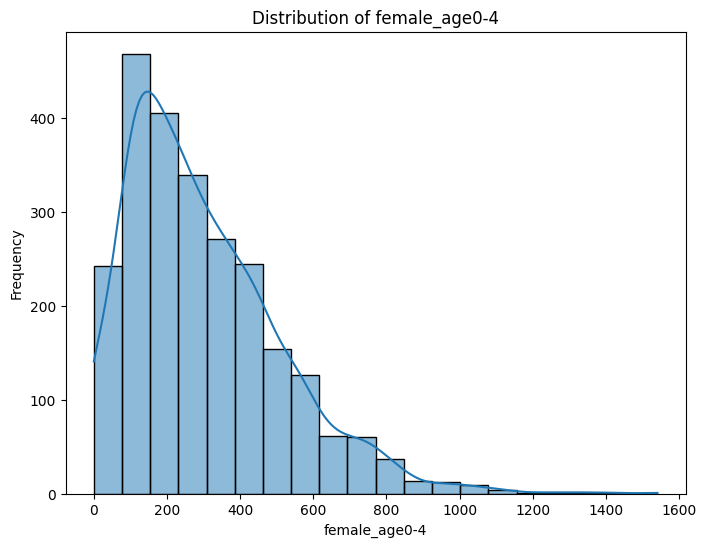

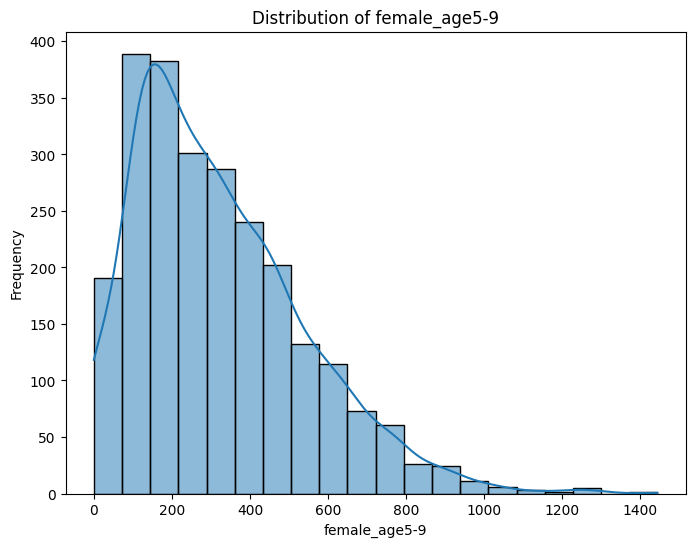

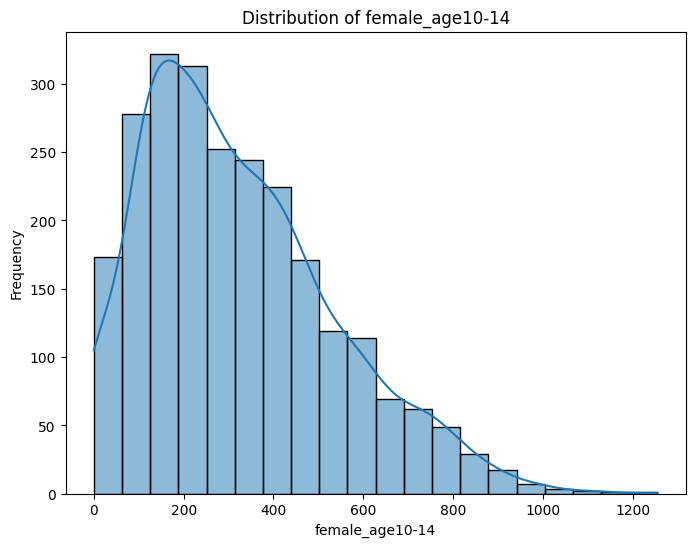

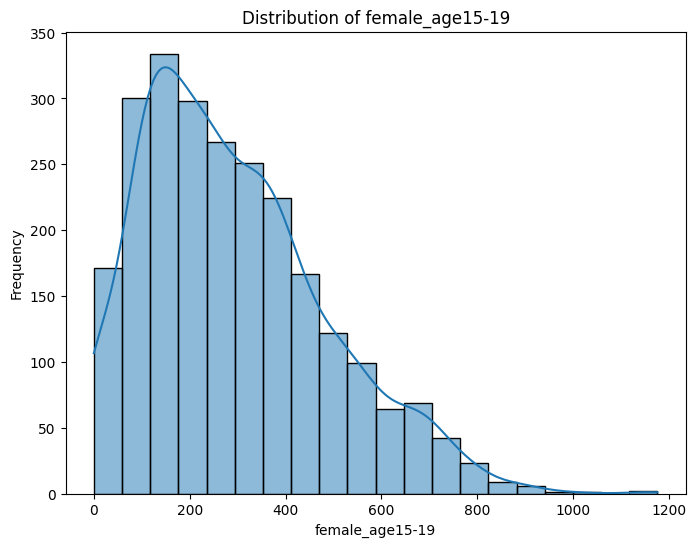

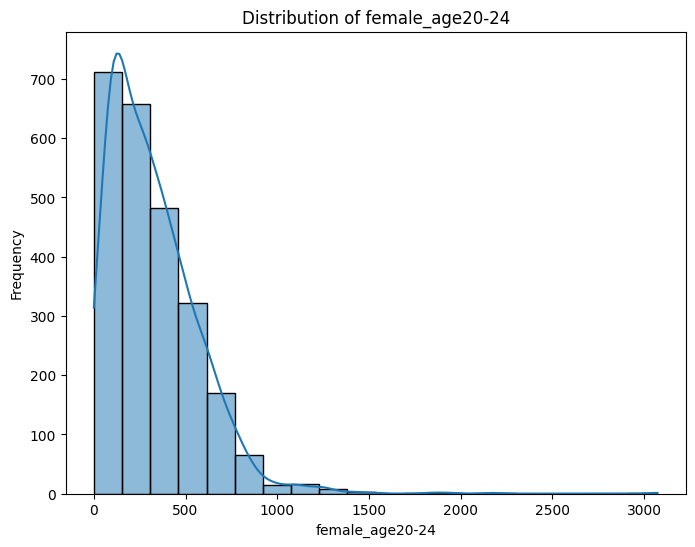

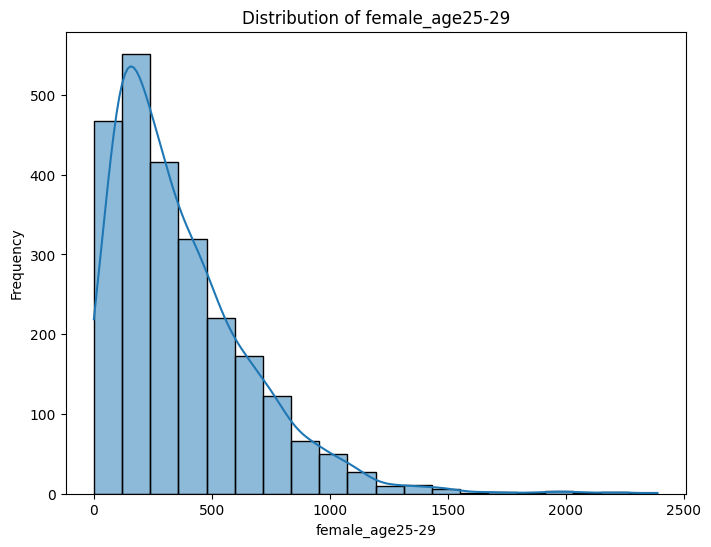

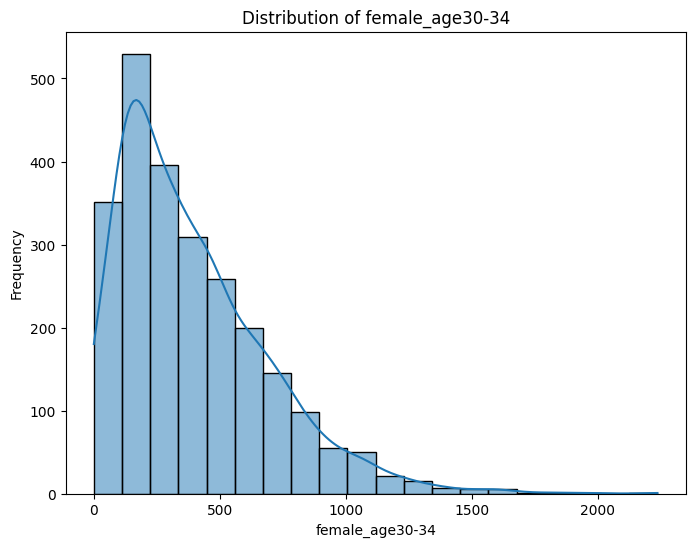

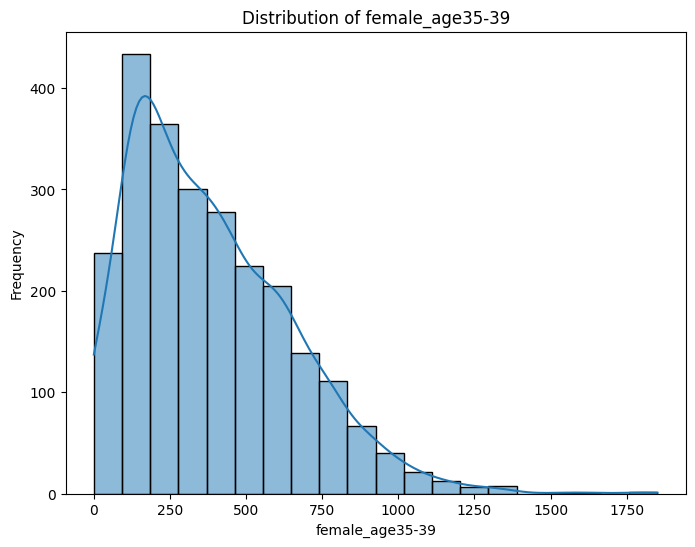

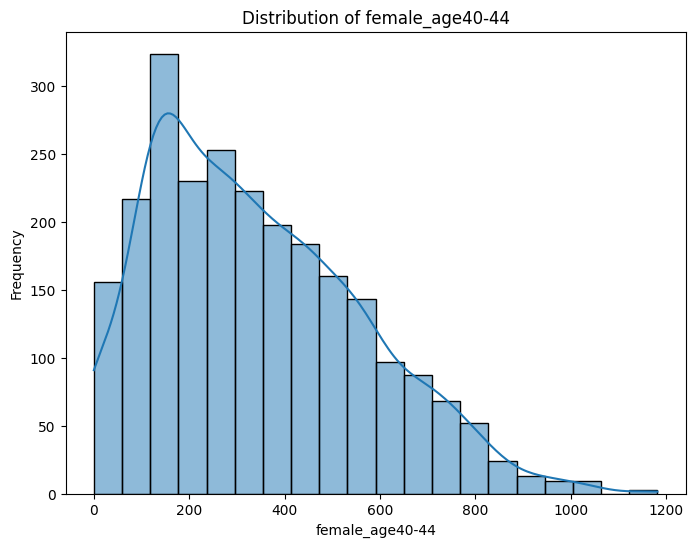

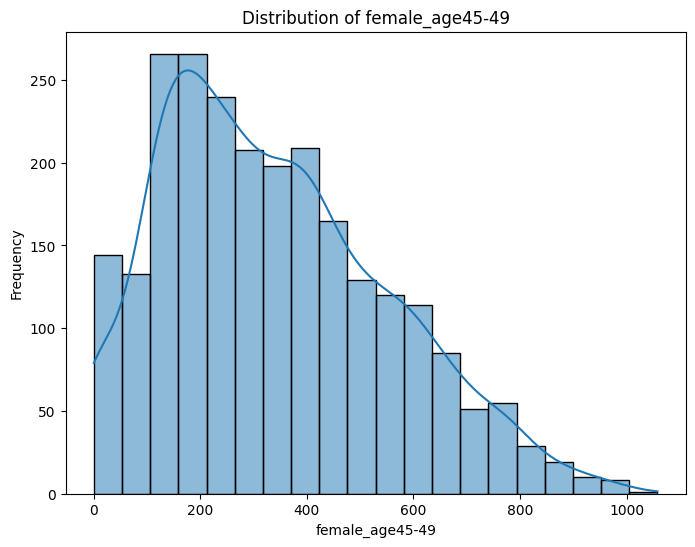

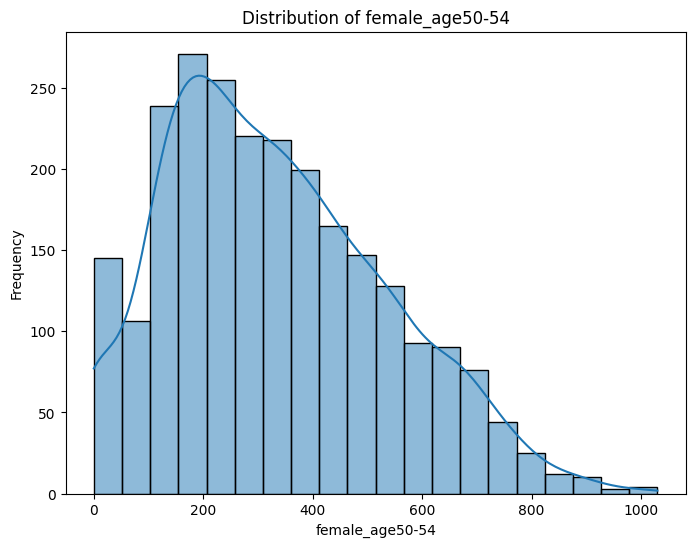

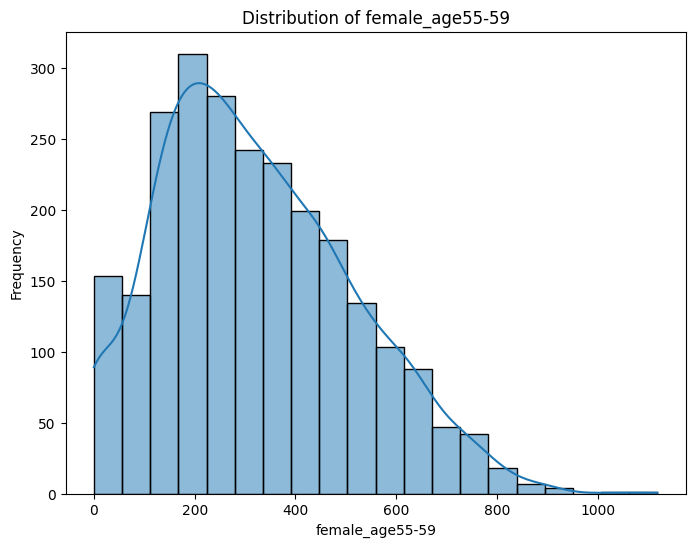

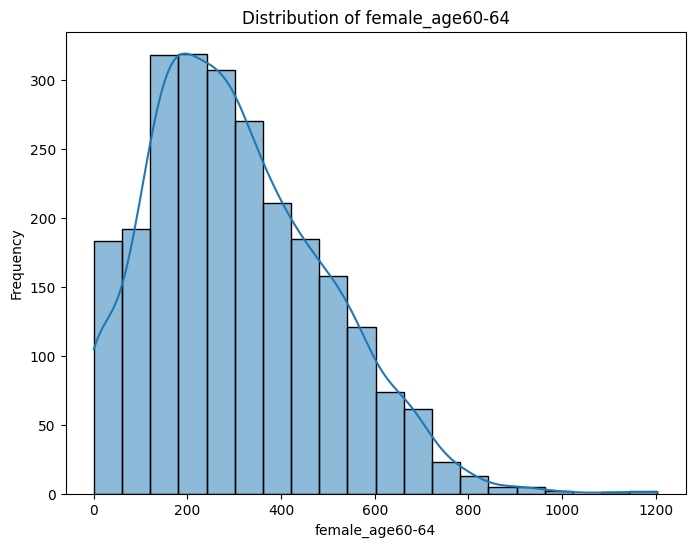

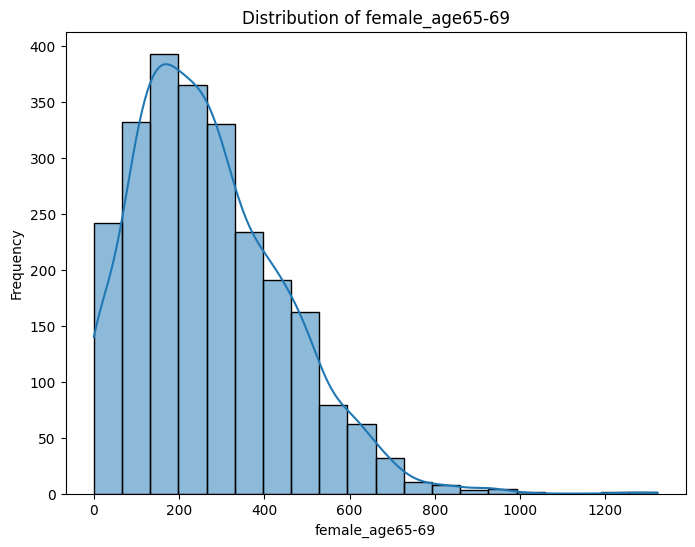

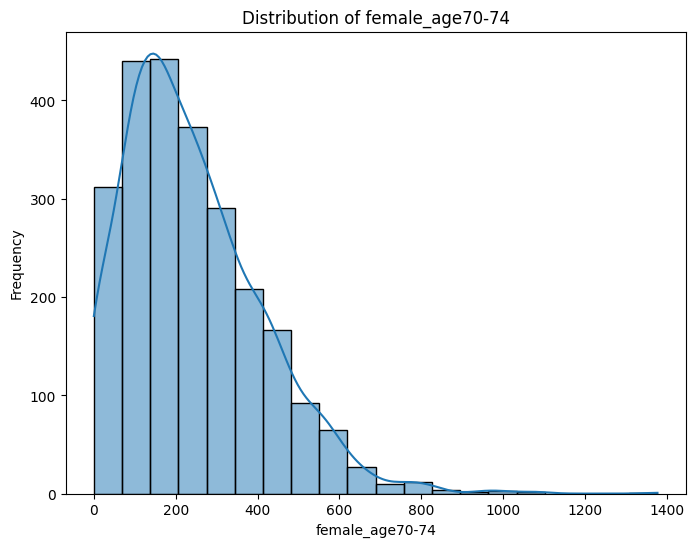

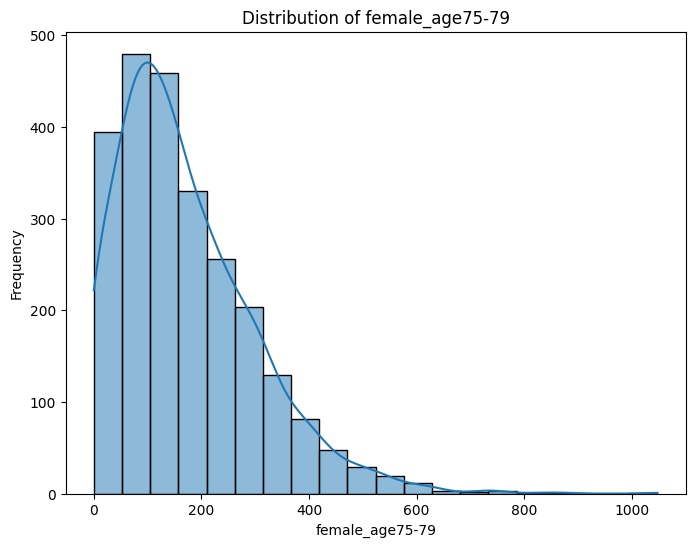

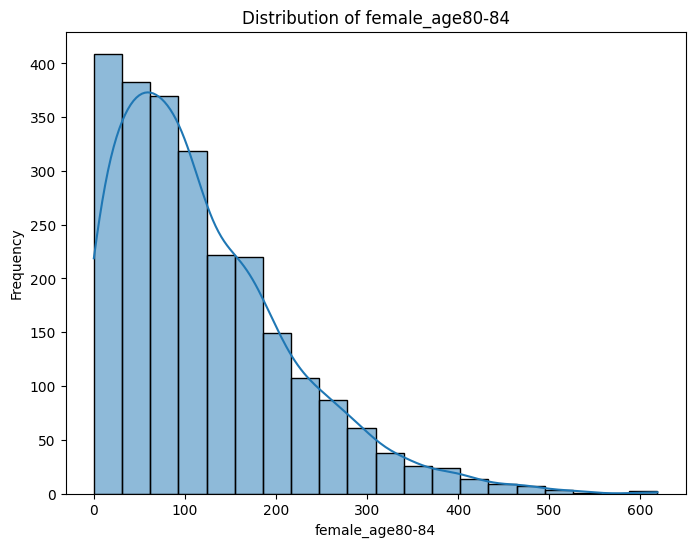

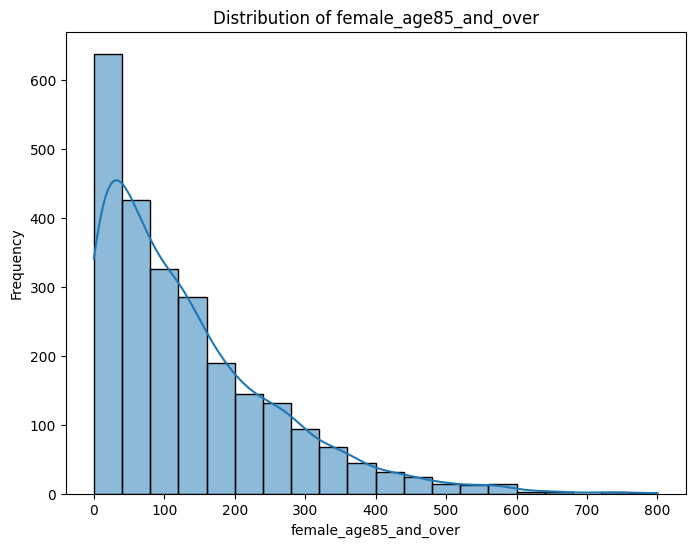

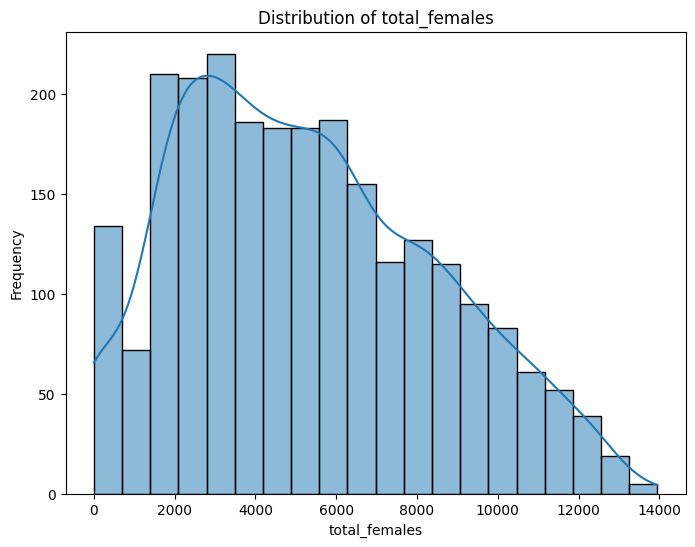

In [47]:
for col in female_numericals:
    plot_distribution(population_female, col)

- AFTER REMOVAL

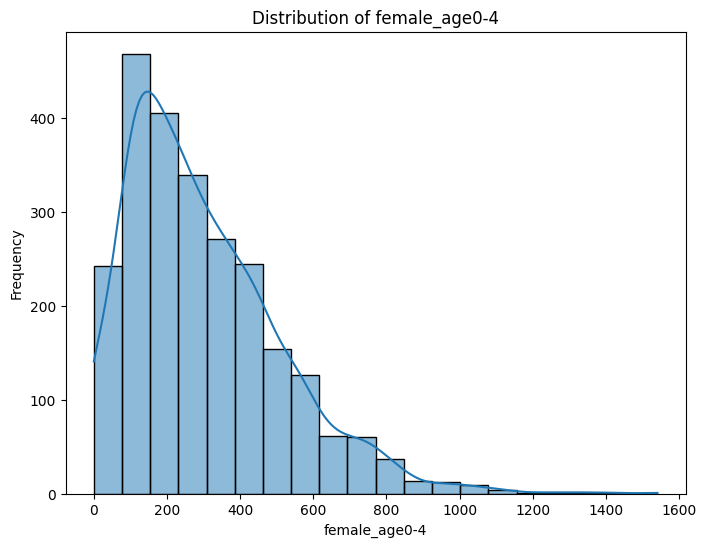

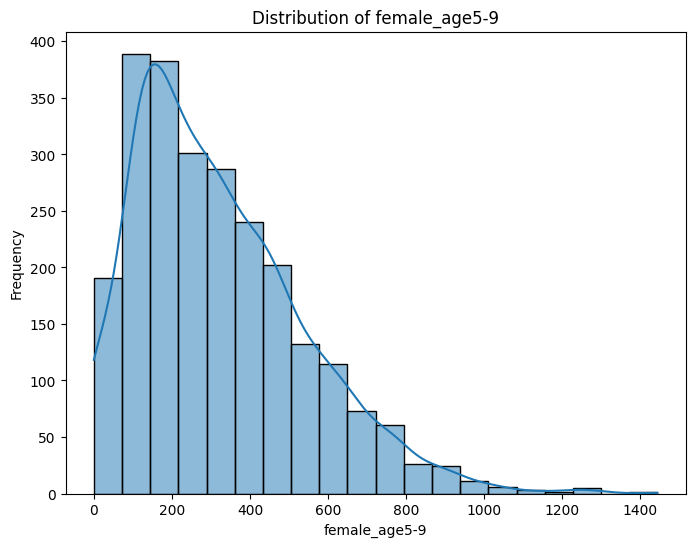

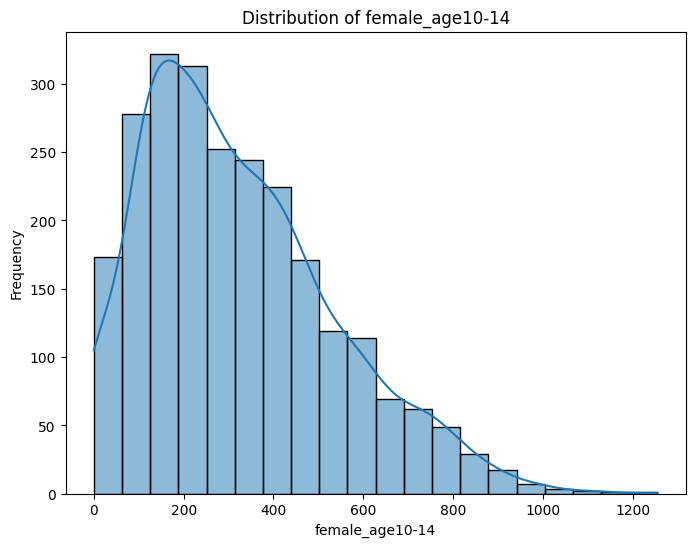

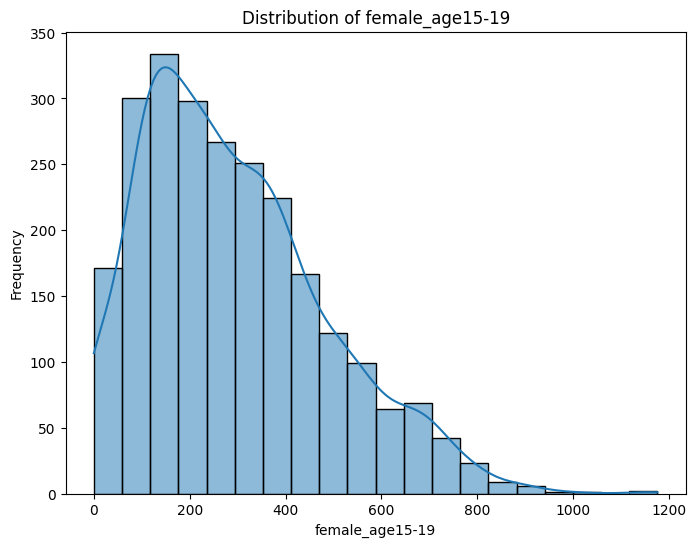

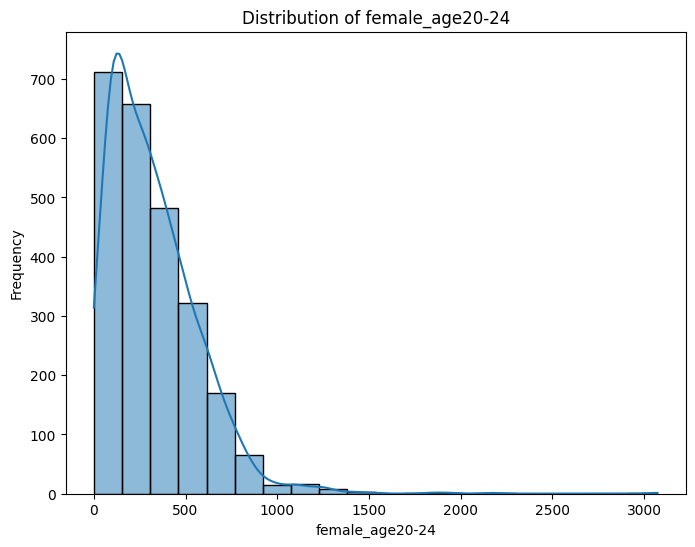

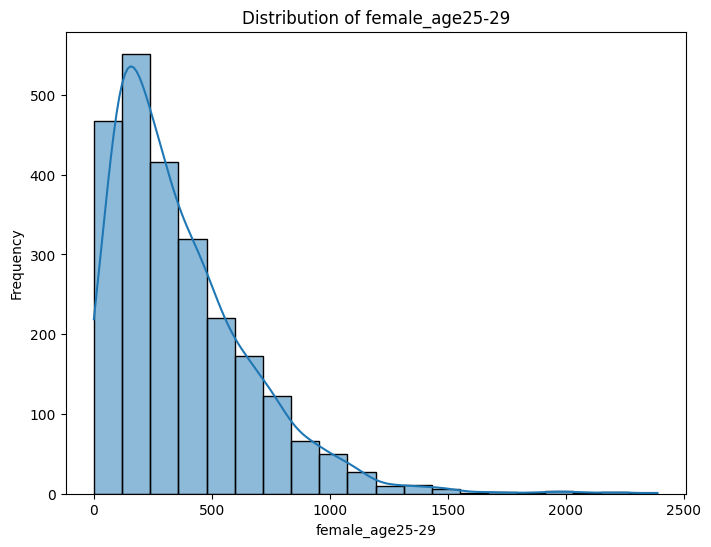

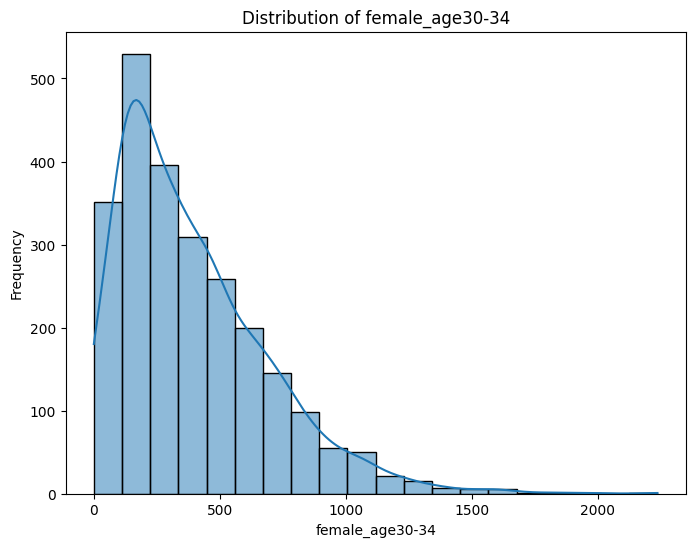

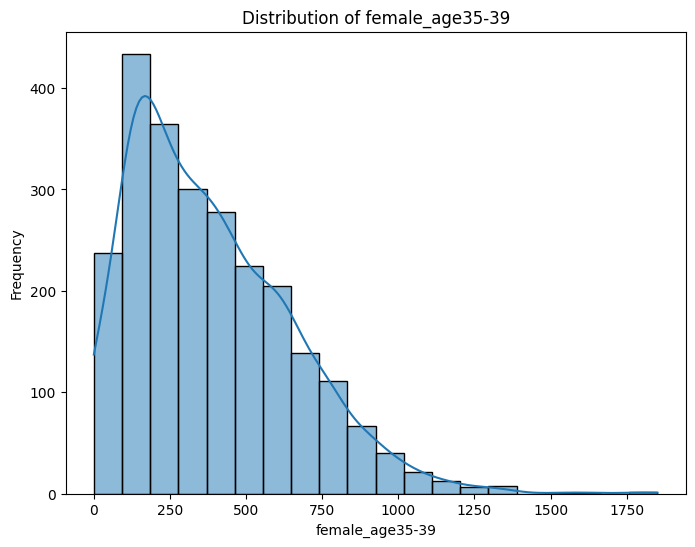

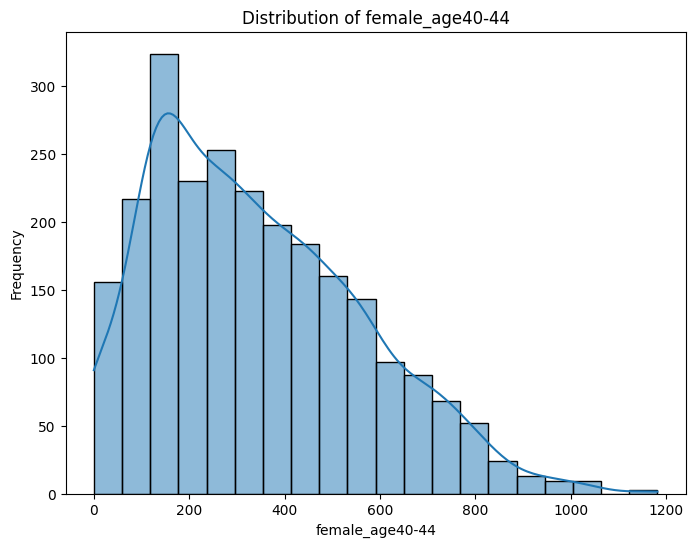

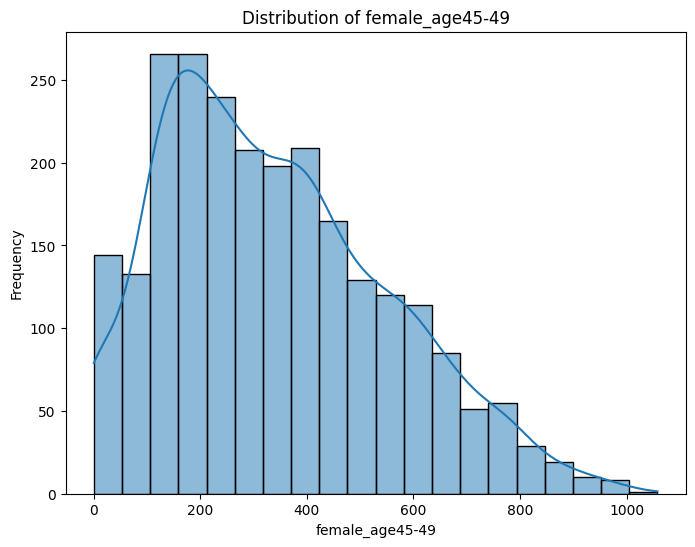

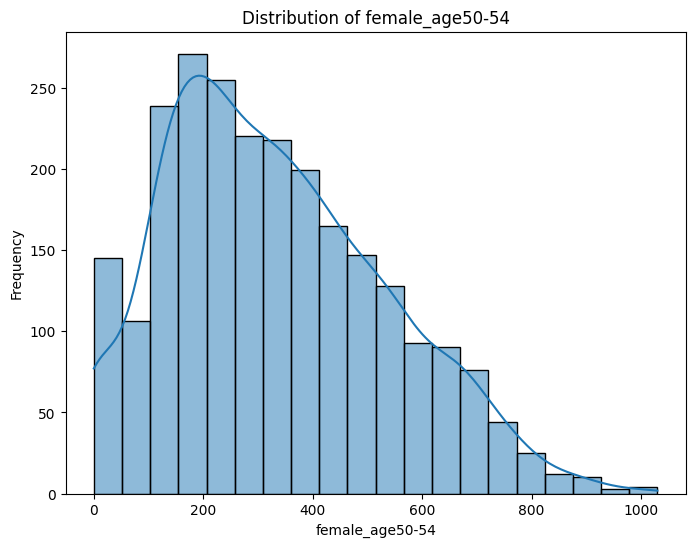

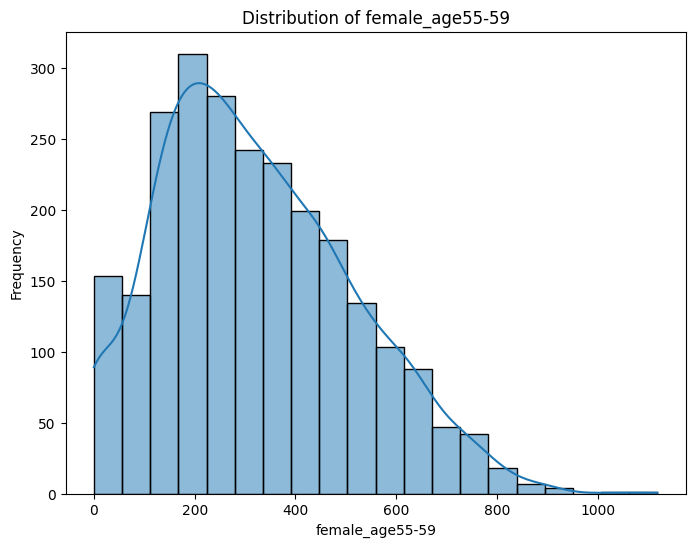

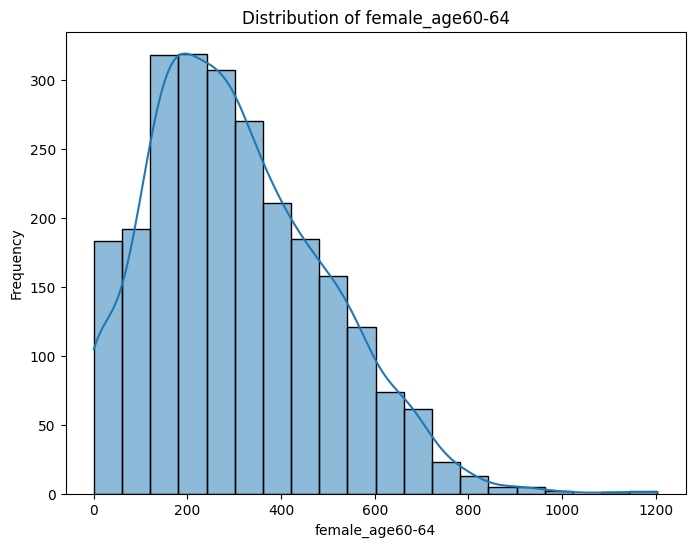

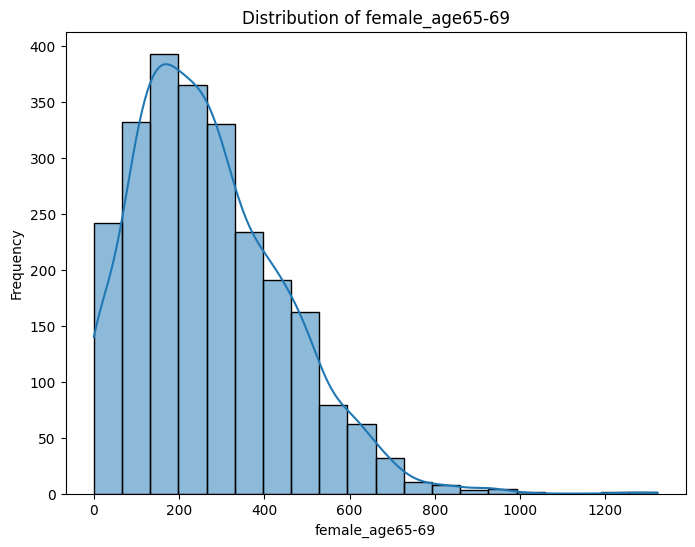

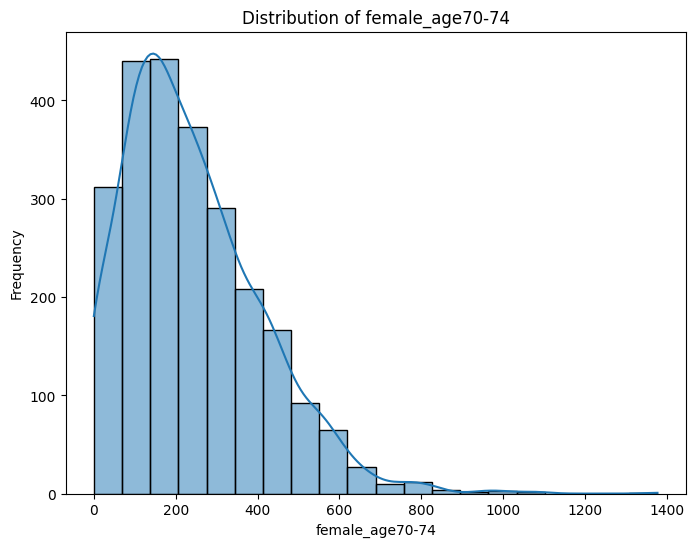

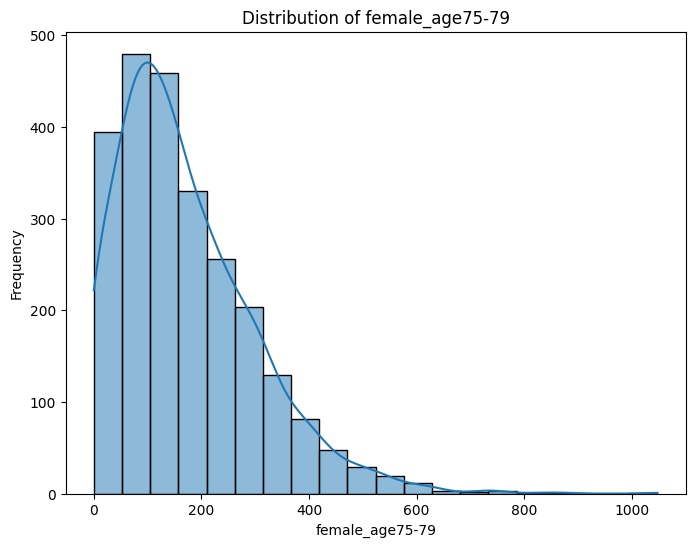

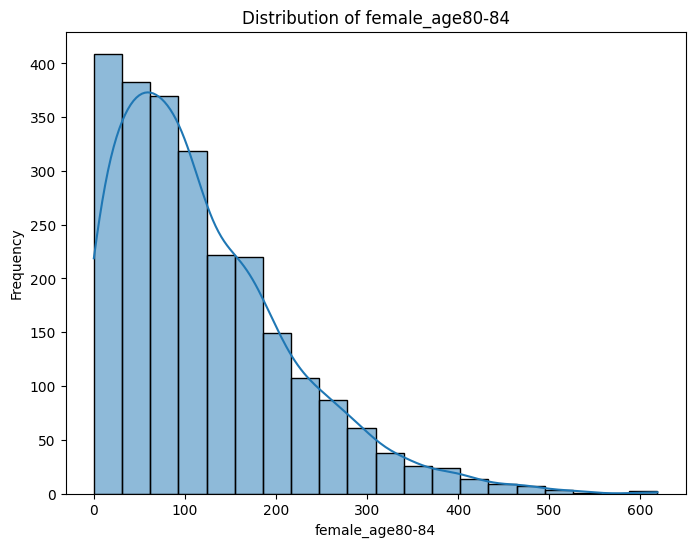

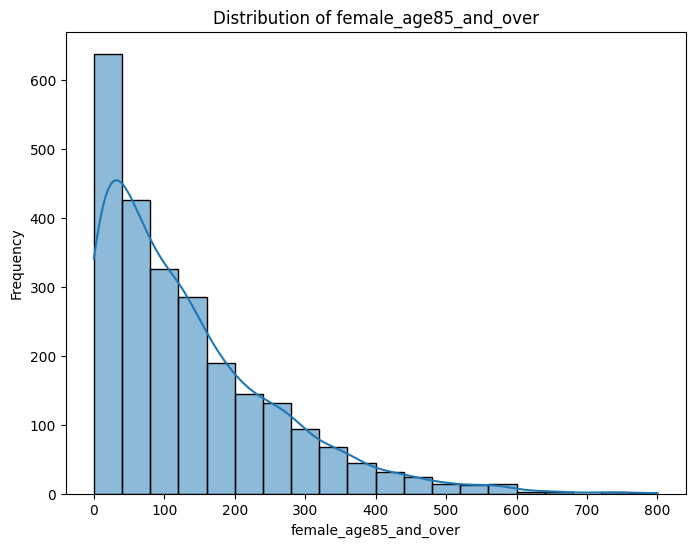

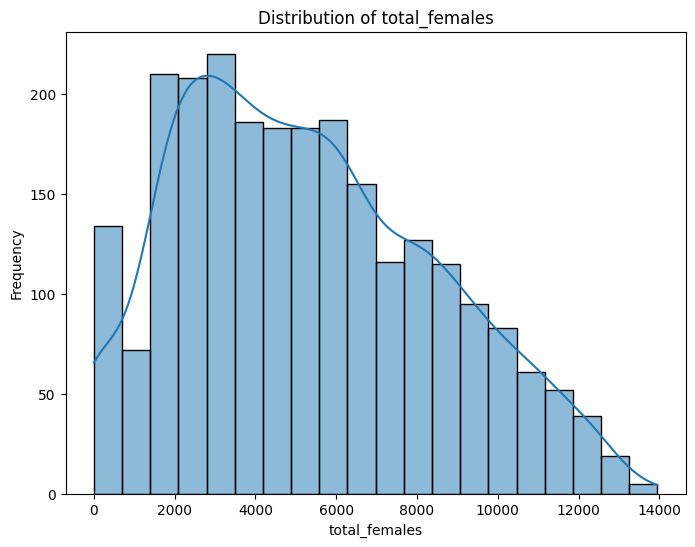

In [48]:
# Go columns wise first
for col in female_numericals:
    # Calculate the outliers per dataset
    # calculate IQR for column A
    Q1 = population_female[col].quantile(0.25)
    Q3 = population_female[col].quantile(0.75)
    IQR = Q3 - Q1

    # identify outliers
    threshold = 1.5
    curr_df = population_female[(population_female[col] >= Q1 - threshold * IQR) | (population_female[col] <= Q3 + threshold * IQR)]
    plot_distribution(curr_df, col)

- Distribution stayed the same, so no need to remove outliers